In [247]:
from pyraf import iraf
from iraf import obsutil
import subprocess
from astropy.table import Table
import os
import csv
#in the furture make packages and import common functions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pyraf import gwm
from astropy.io import ascii
import numpy as np
from astropy.stats import sigma_clip

In [129]:
imagename = '/data/mj1e16/kepler/cal/kplr2009114174833_ffi-cal.fits'

In [35]:
def makeConfig(valList,defaultDir='/home/mj1e16/sextractor/sextractor-master/config/',attributeList=['DETECT_THRESH','DETECT_MINAREA','BACK_FILTERSIZE','BACK_SIZE']):
    
    with open(defaultDir+'/default.sex','r') as f:
        data  = f.read()
    
    catLocFinder = 'CATALOG_NAME'
    catname = 'test_PSF.cat'
    nameLoc = data.find(catLocFinder) + len(catLocFinder)
    endLoc = data[nameLoc:].find('#') + nameLoc
    newData = data[:nameLoc] + ' '+catname+' ' + data[endLoc:]
    data = newData 
        
    for x in range(len(valList)):
        nameLoc = data.find(attributeList[x]) + len(attributeList[x])
        endLoc = data[nameLoc:].find('#') + nameLoc
        newData = data[:nameLoc] + ' '+str(valList[x])+' ' + data[endLoc:]
        data = newData    
    
    
    confName = 'default_PSF.sex'
    with open(defaultDir+confName,'w') as f:
        f.write(data)
    return(confName,catname)

In [36]:
def findObjects(imagename,confName,catName,defaultDir='/home/mj1e16/sextractor/sextractor-master/config/'):
    
    os.chdir(defaultDir)
    subprocess.call(['sex',imagename,'-c',confName])
    assoc = Table.read(catName,format='ascii.sextractor')
    
    return assoc

In [209]:
def cleanLogFile(logfile,imageName='/data/mj1e16/ke'): # imagename up to a max of 15 chars
    with open(logfile,'r') as f:
        string = f.read()

    string = string.replace('NOAO/IRAF V2.16','#NOAO/IRAF V2.16')
    string = string.replace('Image','     ')
    string = string.replace(imageName,'               ')
    string = string.replace('SAT','')
    string = string.replace('Average','#Average')

    with open(logfile,'w') as f:
        f.write(string)

In [255]:
def findPSF(outTable,imageName,extension,imageshape=[1070., 1132.],pixelsize=3.98):
    imageName += '[{}]'.format(extension)
    print(imageName)
    df = outTable.to_pandas()
#     print(len(df))
#     dfslim = df #.loc[df['ELLIPTICITY'] <= 0.1]
#     dflen = len(dfslim)
#     top10 = int(dflen/5)
#     newdf = dfslim.nlargest(top10,'FLUX_ISO')
#     df2 = newdf[50:top10]
    df2 = df
    print(len(df2))
    os.chdir('/home/mj1e16/iraf/')
    
    xlength = imageshape[0]
    ylength = imageshape[1]
    nsegs = 15
    
    xsegment = xlength/nsegs
    ysegment = ylength/nsegs
    #print(xsegment)
    PSF = []
    for xsegs in range(nsegs):
        lowx = xsegs*xsegment
        highx = lowx+xsegment
        psf = []
        for ysegs in range(nsegs):
            #print(lowx,highx)
            irafLog = 'logfile_{}_x{}_y{}'.format(extension,xsegs,ysegs)
            
            lowy = ysegs*ysegment
            highy = lowy+ysegment
            regiondf = df2.loc[(df2['Y_IMAGE'] >= lowy) & (df2['Y_IMAGE'] <= highy) & (df2['X_IMAGE'] >= lowx) & (df2['X_IMAGE'] <= highx)]
            xcoords = regiondf['X_IMAGE'].tolist()
            ycoords = regiondf['Y_IMAGE'].tolist()
            print(len(xcoords),xsegs,ysegs)
            with open('starlist','w') as f:
                writer = csv.writer(f,delimiter=' ')
                writer.writerows(zip(xcoords,ycoords))

            with open('starlist','a') as f:
                f.write('q')
            if len(xcoords) >= 9:
                with open('logfile_{}_x{}_y{}'.format(extension,xsegs,ysegs),'w') as f:
                    f.write('')
                psfmeasure(imageName,coords='markall',logfile=irafLog,imagecur='starlist') 
                cleanLogFile(irafLog)
                data = ascii.read(irafLog,guess=False)
                fwhm = data['FWHM']
                filtered_data = sigma_clip(fwhm, sigma=3, iters=5)
                psf.append(np.median(filtered_data)*pixelsize)


            else:
                print('Not enough in region {} {}'.format(xsegs,ysegs))
                psf.append(0) #'N/A')
        PSF.append(psf)
            
    return PSF

In [256]:
# def findAveragePSF(): # not a real function just saving code incase
#     with open('logfile_{}_x{}_y{}'.format(extension,xsegs,ysegs),'r') as f:
#         bigstring = f.read()
#     finder = 'Average full width at half maximum (FWHM) of '
#     loc1 = bigstring.find(finder) +len(finder)
#     loc2 = bigstring[loc1:].find('\n')
#     print(loc1,loc2)
#     PSF[xsegs].append(bigstring[loc1:loc1+loc2])

In [257]:
extensions = [44,63,9]
psf = []


for ext in extensions:

    psf.append(findPSF(outTable,imagename,ext))

/data/mj1e16/kepler/cal/kplr2009114174833_ffi-cal.fits[44]
7274
(25, 0, 0)
z1=43.74463 z2=304.1827
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:14:01 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   66.76   39.78    0.00   1.847    0.31      81
                  67.05   39.60    0.17   1.683    0.35      43
                  67.06   39.60    0.14   1.707    0.33      40
                  22.00   20.54    4.66   1.490    0.12       0
                  59.72   39.60    0.15  16.018    0.64      -3
                  59.72   39.60    0.15  16.028    0.63      -4
                  67.05   39.60    0.17   1.684    0.35      41
                  67.05   39.60    0.21   1.658    0.30      47
                  39.64   48.17    5.36   1.253    0.81     -33
                  67.02   39.61    0.36   1.528    0.27     -86
                  66.76   39.

(25, 0, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:14:28 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   13.08  385.79    1.99   0.934    0.00       0
                  61.07  384.97    2.35   1.050    0.04      10
                  44.93  380.70    0.78   1.037    0.12     -72
                  61.07  384.97    2.35   1.050    0.04      10
                  39.92  397.88    2.57   1.399    0.89      15
                  39.92  397.88    2.57   1.399    0.89      15
                  37.10  407.74    0.79   5.460    0.36     -45
                  52.09  387.55    0.16  21.535    0.58      38
                  38.80  408.99    1.62   1.078    0.37      77
                  63.76  407.71    2.06   1.457    0.48     -53
                  13.37  420.62    1.04   1.016    0.00       0
                  63.76  407.71    2.05   1.457    0.

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:14:40 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   35.21  746.23    5.40   1.672    0.50      61
                  27.91  767.34    1.80   1.993    0.68      13
                  35.21  745.92    5.36   1.591    0.37      60
                  59.50  751.45    2.96   1.174    0.17      80
                  59.50  751.45    2.96   1.174    0.17      80
                  59.50  751.45    2.96   1.174    0.17      80
                  51.00  734.38    1.40   4.736    0.40      56
                  79.22  764.43    2.05  13.318    0.54      69
                  49.04  737.52    1.58   5.832    0.61      45
                  57.83  747.04    2.26  11.019    0.53      64
                  32.28  724.21    2.88   2.800    0.43      34
                  59.79  720.16    4.56   1.270    0.66     -74
                  57.25  709.49    2.70   4.100    0.30     -89
                  39.75  728.82    2.29 

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:14:52 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   26.57  906.75    2.00   2.058    0.58      80
                  72.23  894.04    1.38   9.709    0.18     -86
                  73.18  899.41    1.93   5.108    0.20     -20
                  17.15  892.13    3.53   5.072    0.87      -8
                  28.49  873.76    1.76   1.551    0.92      39
                  20.15  879.36    6.19   1.423    0.00       0
                  20.15  879.36    6.19   1.423    0.00       0
                  73.08  868.26    0.21   1.562    0.40     -88
                  73.06  868.25    0.23   1.557    0.48     -85
                  36.02  857.57    0.00   3.506    0.46     -71
                  73.08  868.26    0.20   1.562    0.36      89
                  72.76  868.29    0.55   1.376    0.16      87
                  35.68  857.48    0.92   4.120    0.60      63
                  35.70  857.50    1.03 

                 126.22  131.18    3.38   1.089    0.07     -40
                  76.30  138.56    3.23   1.018    0.08     -66
                  79.48  139.40    2.30   8.129    0.84      12
                 126.22  131.18    3.38   1.089    0.07     -40
                  63.17  137.04    0.00   3.028    0.30       6
                 133.89  137.79    6.95   5.716    0.48     -53
                 103.19  146.44    5.87   2.800    0.14      44
                 135.79  146.49    5.15   5.828    0.27     -86
                  85.01  145.25    4.51   1.273    0.49     -60

  Average full width at half maximum (FWHM) of 6.4062
(32, 1, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:15:10 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  110.75  161.14    3.08   4.272    0.72     -50
                  84.67  145.35    3.51   1.418    0.40     -6

(48, 1, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:15:20 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   75.39  384.62    2.71   4.284    0.73       2
                  73.68  384.84    3.16   1.084    0.08     -56
                  75.39  384.62    2.70   4.284    0.73       2
                 136.60  367.16    3.39   1.187    0.09     -34
                 100.91  383.74    1.50   1.161    0.20     -51
                 118.22  382.60    3.76   1.102    0.14     -43
                 140.44  387.82    4.46   1.491    0.71       7
                 110.64  390.75    1.21   1.195    0.08     -58
                 129.85  405.56    4.57   1.086    0.18     -84
                 110.64  390.75    1.21   1.195    0.08     -58
                 107.08  387.59    0.47  11.019    0.64      31
                 132.15  393.17    7.89   1.235    0.

                 107.11  591.87    4.64   1.830    0.33      -5
                 112.52  610.45    1.99  12.069    0.24     -28
                  88.54  611.04    0.22  14.778    0.18     -30
                 109.90  605.69    3.10   1.406    0.71     -10
                  83.05  613.37    1.08   3.172    0.14      24
                  93.27  595.23    2.93   1.150    0.04     -30
                  77.88  589.69    5.63   1.475    0.96     -22
                 118.68  584.88    2.93   6.868    0.40     -59
                  93.25  595.22    2.94   1.163    0.06     -41

  Average full width at half maximum (FWHM) of 10.3733
(27, 1, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:15:30 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  153.31  644.73    0.00   3.406    0.22     -60
                 100.84  680.93    6.80   1.994    0.41     -

                 107.55  835.54    5.52   1.833    0.32     -11

  Average full width at half maximum (FWHM) of 14.3956
(24, 1, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:15:43 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  107.27  981.92    0.00  17.668    0.93      -3
                 160.07  990.75    0.50   1.835    0.71      56
                 160.28  990.56    0.28   1.855    0.27      71
                  99.40  982.49    0.00   2.138    0.16     -66
                 157.36  989.39    0.46   7.560    0.71      34
                 135.10  954.77    2.87   1.229    0.55     -20
                 102.97  954.91    3.06   1.105    0.04     -41
                  74.98  962.30    4.94   1.460    0.58     -81
                 100.74  954.25    2.68   5.804    0.30      30
                  99.41  982.00    0.05   2.118    0.31     

(42, 2, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:15:51 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  199.73  151.67    3.53   1.204    0.31      85
                 152.85  157.13    5.86   1.362    0.67      69
                 158.64  160.57    0.25  14.208    0.78     -54
                 162.88  157.07    0.52  22.295    0.90     -72
                 183.98  156.01    5.07   1.059    0.19     -32
                 183.93  156.01    5.03   1.082    0.28       5
                 202.74  165.92    4.40   1.087    0.23     -80
                 173.31  164.37    5.81   5.640    0.50      -3
                 175.56  154.54    3.53   6.708    0.58      30
                 196.32  179.24    2.40  22.714    0.37     -51
                 153.99  170.91    0.47  15.668    0.47     -36
                 187.89  182.33    3.28   3.908    0.

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:16:01 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  214.80  377.69    1.76  22.594    0.22     -58
                 142.94  394.40    1.05  15.588    0.46      50
                 184.80  381.81    4.64   1.271    0.30     -26
                 160.66  383.55    5.24   1.301    0.87      55
                 203.14  363.42    3.45  13.978    0.59     -17
                 176.48  386.48    4.95   1.951    0.61     -27
                 184.80  381.81    4.64   1.271    0.30     -26
                 160.66  383.55    5.24   1.301    0.87      55
                 204.63  394.45    3.29   5.868    0.73      -1
                 160.25  408.73    2.29   8.949    0.78      36
                 205.49  394.18    3.09   4.224    0.49      -7
                 160.28  409.92    2.25   8.249    0.72      31
                 154.10  407.62    2.12   7.028    0.62      17
                 178.24  377.51    3.27 

(19, 2, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:16:09 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  190.38  699.32    1.02  24.914    0.79      75
                 200.47  670.43    6.22   1.744    0.38      71
                 159.29  670.00    6.11   1.558    0.63      87
                 146.47  663.31    4.68   7.800    0.62      52
                 172.00  662.31    4.82   1.142    0.09     -19
                 203.53  657.31    6.49   1.547    0.64     -41
                 214.51  665.84    7.36   4.940    0.70      76
                 185.74  679.97    1.89  19.575    0.81      88
                 173.96  658.20    3.71  10.479    0.66     -89
                 195.46  639.76    4.91   1.421    0.45      75
                 220.63  647.64    6.25   9.669    0.85     -40
                 218.81  614.54    2.10  38.612    0.

                 153.16  853.75    4.02   1.096    0.18     -84
                 135.53  850.02    1.48   4.356    0.47     -78
                 214.17  832.92    5.22   1.162    0.12     -14
                 183.14  842.75    7.42   1.215    1.00      13
                 190.23  842.15    3.25   2.498    0.44     -62
                 144.00  829.66    3.61   1.071    0.08     -67
                 214.17  832.92    5.22   1.162    0.11     -15
                 139.49  831.08    2.72  10.749    0.28     -18
                 190.71  854.81    7.37   2.430    0.89     -15

  Average full width at half maximum (FWHM) of 9.2915
(32, 2, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:16:21 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  160.07  990.75    0.00   1.852    0.68      53
                 178.14  973.45    3.53   1.250    0.10     -

                 244.46  200.92    1.83   6.036    0.22      46
                 238.81  230.81    0.12  12.049    0.78      89
                 274.19  212.47    6.33   1.535    0.42     -44
                 293.05  234.33    3.54  17.988    0.71      58
                 228.10  225.40    4.90   4.292    0.52     -86
                 245.48  202.11    2.02  10.609    0.50      16
                 242.96  235.65    0.00   9.879    0.54      13
                 255.75  214.54    5.09   2.340    0.65      11
                 274.13  212.41    6.37   1.463    0.44     -43
                 263.29  237.22    2.40  15.808    0.67     -10
                 243.31  235.65    0.00  10.469    0.55      12
                 281.68  194.43    2.14  14.118    0.25     -36
                 238.80  235.52    0.14   2.478    0.14     -75
                 228.10  225.40    4.90   4.292    0.52     -86

  Average full width at half maximum (FWHM) of 12.3717
(41, 3, 3)
** Select stars to measure with 'm' a

                 236.90  424.77    0.12   1.842    0.35     -10
                 236.43  424.91    0.27   1.946    0.09       0
                 253.65  452.29    4.04   1.609    0.54     -78
                 237.01  424.77    0.11   1.830    0.35      -9
                 250.71  424.65    0.00  30.633    0.68      -1
                 230.26  451.18    3.78  12.858    0.82     -38
                 235.21  447.73    4.29   1.288    0.23      47
                 253.80  452.39    4.30   1.463    0.55     -50
                 234.75  447.61    4.61   1.467    0.80      36
                 274.13  456.11    3.06   5.304    0.42     -42
                 253.64  452.30    4.03   1.623    0.60     -81

  Average full width at half maximum (FWHM) of 5.3164
(55, 3, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:16:47 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SA

                 251.47  612.68    5.58   1.448    0.96      36
                 267.82  615.06    2.09   1.230    0.41      -8
                 274.43  613.89    1.20  16.178    0.40     -10
                 232.13  627.15    3.65   8.649    0.75      84
                 267.81  615.04    2.48   1.146    0.19     -57
                 231.63  597.63    0.67  13.768    0.54     -64
                 267.81  615.04    2.48   1.146    0.19     -57
                 232.13  627.15    3.65   8.649    0.75      84

  Average full width at half maximum (FWHM) of 13.1696
(44, 3, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:16:57 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  210.15  729.33    2.80  14.018    0.17     -52
                 266.05  751.04    5.59   1.234    0.57     -23
                 286.04  735.32    1.40  28.613    0.35     -

                 286.35  846.94    2.21   6.280    0.50      16
                 230.93  851.92    3.01   1.097    0.08     -23
                 230.81  854.66    2.26   6.588    0.53      37
                 249.71  833.38    0.00   9.149    0.40     -13
                 214.17  832.92    3.55   1.162    0.11     -15
                 231.86  838.87    2.43   1.112    0.24      54
                 265.48  853.31    3.20   1.639    0.29     -24
                 280.98  895.31    2.13   1.461    0.24      57
                 265.79  832.10    1.67   1.165    0.03     -46
                 249.17  833.44    0.00   7.832    0.41     -12

  Average full width at half maximum (FWHM) of 11.5907
(33, 3, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:17:03 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  246.99  966.43    2.37   6.672    0.09     

                 317.95  221.11    0.46   9.159    0.09      80
                 306.14  192.32    2.26   3.614    0.46     -42
                 306.14  192.34    2.26   3.590    0.48     -42
                 346.17  203.59    2.25  10.389    0.40      78
                 305.42  192.94    1.85   1.389    0.35      -2
                 317.95  221.11    0.46   9.159    0.09      80
                 310.32  214.39    0.15  29.833    0.33      56
                 307.37  206.95    5.37   1.152    0.92     -81
                 305.33  194.96    2.07   5.420    0.12     -47
                 280.02  191.86    0.89  15.618    0.15     -38
                 318.44  209.15    6.94   1.476    0.00       0
                 321.02  223.31    0.78   1.469    0.56       9
                 347.14  207.96    3.07   1.040    0.07     -50
                 309.65  215.21    4.80   1.175    0.06      43
                 300.21  210.74    4.73   1.082    0.18     -35
                 320.41  223.21    0.56 

                 333.89  429.51    3.75   1.094    0.45     -33
                 348.30  435.78    5.07   1.629    0.81      40
                 309.75  420.23    1.86   2.360    0.92      20
                 323.61  422.16    0.35   2.118    0.32      10
                 291.76  435.50    3.31  11.309    0.16     -32
                 327.34  439.70    5.71   1.318    0.15       1
                 274.08  456.15    1.77   5.352    0.42     -42
                 324.59  452.49    3.69   1.133    0.14     -65
                 333.85  458.63    3.12   4.576    0.79     -61
                 296.65  436.74    5.04   1.205    0.34       8
                 324.58  452.49    3.69   1.111    0.13     -64

  Average full width at half maximum (FWHM) of 12.3371
(44, 4, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:17:36 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA S

                 301.07  609.78    5.81   2.228    0.32       2
                 360.11  643.11    0.51  13.718    0.24       6
                 281.70  615.51    2.66   1.171    0.06      -3
                 333.36  584.45    0.00  20.335    0.18      77
                 291.97  605.69    5.30   1.208    0.78      74

  Average full width at half maximum (FWHM) of 15.8326
(34, 4, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:17:42 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  326.08  746.33    1.21   1.184    0.03      77
                 340.07  746.51    3.32   1.495    0.51     -39
                 326.08  746.33    1.21   1.184    0.03      77
                 283.59  748.71    2.49   1.266    0.48     -54
                 344.23  734.61    6.77   1.006    0.00       0
                 290.06  723.48    2.33  10.549    0.82     -

                 281.44  934.21    4.24   2.478    0.64      24
                 345.64  937.21    5.24   1.284    0.13     -88
                 345.12  925.93    8.15   1.701    0.95     -87
                 356.34  911.51    3.09  12.419    0.63      35
                 280.89  932.97    4.16   5.412    0.51      27
                 336.89  915.57    7.74   1.445    0.97      47
                 302.00  950.72    2.42   7.108    0.41      19
                 358.50  913.48    3.02  18.055    0.42      37
                 328.61  925.15    7.73   7.904    0.61     -33
                 317.27  951.78    4.92   1.146    0.16     -57
                 362.64  951.80    0.07   4.060    0.43      80
                 299.00  950.63    3.51   1.325    0.70      66
                 323.94  892.82    3.41  15.678    0.49     -60
                 320.68  909.98    4.37   3.806    0.59      80
                 323.94  892.82    3.41  15.678    0.49     -60

  Average full width at half maximum (F

(32, 5, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:18:08 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  422.04  239.47    5.19   1.269    0.54     -43
                 415.72  233.13    3.46   9.379    0.39      55
                 392.65  239.25    2.80   1.149    0.39      -8
                 396.24  226.00    3.15   1.076    0.01     -54
                 363.94  232.51    0.18  28.134    0.20     -18
                 415.14  237.19    4.68   1.189    0.47     -28
                 380.96  225.27    4.33   1.155    0.08     -46
                 361.52  231.99    0.64  22.514    0.67     -57
                 392.65  239.25    2.80   1.149    0.39      -8
                 408.10  226.76    5.10   1.263    0.33     -77
                 356.39  240.78    1.57   1.032    0.07     -51
                 356.40  240.77    1.57   1.018    0.

                 416.59  518.47    3.25   1.573    0.64      55
                 364.97  502.31    5.07   1.165    0.16      -2
                 422.49  515.15    0.00  21.735    0.32     -46
                 394.76  515.52    3.53   3.624    0.87     -42
                 388.84  499.31    1.74  10.299    0.39      51
                 379.17  509.12    4.08   9.679    0.77     -22
                 390.73  500.65    2.27  13.988    0.52      58
                 370.17  533.77    2.38  10.269    0.27      79
                 416.18  518.80    2.90   2.780    0.35     -60
                 393.87  532.31    5.75   1.227    0.93     -89
                 365.82  522.89    4.12   1.062    0.11      74
                 431.37  511.64    0.13   8.000    0.64     -60
                 431.37  511.64    0.13   7.996    0.63     -60
                 336.67  532.64    0.92  24.074    0.48     -71

  Average full width at half maximum (FWHM) of 18.2116
(34, 5, 7)
** Select stars to measure with 'm' a

                 397.69  710.62    1.58  14.458    0.32     -12
                 379.90  687.71    7.21   2.108    0.92     -82
                 361.72  691.88    7.97   1.267    0.00       0
                 374.97  700.07    3.46   9.879    0.43     -77
                 373.19  729.02    5.56   4.568    0.57      56

  Average full width at half maximum (FWHM) of 6.8121
(40, 5, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:18:24 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  402.73  814.89    4.92   1.080    0.00       0
                 382.37  813.26    0.80   5.900    0.55      11
                 414.17  806.88    2.18   1.213    0.53      70
                 361.65  803.68    4.48   1.118    0.08      44
                 400.42  812.44    0.31  33.573    0.15     -19
                 395.55  796.39    2.71   1.456    0.23      

(9, 5, 13)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:18:32 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  372.26 1012.68    2.83  20.455    0.33      61
                 363.70  992.54    4.70   1.098    0.07     -73
                 409.47  984.64    0.32   5.508    0.93      89
                 409.42  983.78    0.00   5.204    0.90     -89
                 395.71  985.65    5.66   1.293    0.02     -84
                 378.20  988.94    4.21  31.473    0.88      -9
                 409.47  984.64    0.27   5.508    0.92      89
                 379.81  975.22    8.22   3.734    0.86      20
                 391.88  992.76    6.21   1.175    0.36      52

  Average full width at half maximum (FWHM) of 5.9782
(0, 5, 14)
Not enough in region 5 14
(31, 6, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options

                 489.93  203.24    5.35   1.372    0.58     -11
                 472.91  217.95    2.86   1.040    0.02      37
                 436.09  199.10    5.97  10.399    0.39      67
                 472.92  217.89    2.73   1.158    0.62      30
                 472.91  217.95    2.86   1.040    0.02      37
                 472.91  217.95    2.86   1.040    0.02      37
                 477.00  223.27    1.76  14.638    0.22      64
                 443.05  221.57    0.00   4.752    0.45       0
                 441.58  221.76    0.19   2.308    0.28     -86
                 435.73  199.25    5.80  13.008    0.43      71

  Average full width at half maximum (FWHM) of 5.2262
(38, 6, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:18:44 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  453.50  223.77    4.69   1.597    0.81       

                 433.68  451.31    0.11   1.429    0.67     -40
                 424.95  437.83    4.64   1.073    0.12      21
                 469.47  439.86    0.40   3.954    0.85       3
                 490.10  446.93    5.46   1.261    0.91      46
                 479.00  440.37    2.11   1.143    0.04     -58
                 467.98  440.24    0.67   1.190    0.04     -34
                 433.72  451.29    0.26   1.326    0.35     -38
                 503.99  454.80    1.24   1.208    0.39     -46
                 467.98  440.21    0.67   1.186    0.04     -21
                 484.84  440.55    4.51   1.835    0.64      -4
                 468.51  441.95    0.04   5.364    0.29     -72

  Average full width at half maximum (FWHM) of 11.8312
(33, 6, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:18:59 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA S

                 432.90  610.92    5.54   1.128    0.08      58
                 432.90  610.92    5.54   1.128    0.08      58

  Average full width at half maximum (FWHM) of 23.7720
(37, 6, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:19:07 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  495.13  747.43    6.59   1.246    0.73     -22
                 447.46  738.90    5.00   1.853    0.71     -80
                 494.84  733.01    0.04  14.318    0.62      43
                 479.08  720.85    1.54   1.238    0.20     -43
                 458.78  749.71    5.87   1.210    0.04      73
                 447.46  738.90    5.00   1.853    0.71     -80
                 477.23  752.00    6.50   1.197    0.32      85
                 489.54  760.56    4.13  16.278    0.38       0
                 458.78  749.71    5.87   1.210    0.04      

(29, 6, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:19:13 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  460.00  979.78    1.37   1.612    0.95     -89
                 448.61  969.80   10.27   1.592    0.99     -11
                 460.00  986.03    0.37   1.545    0.96      89
                 432.00  953.29    6.34   1.395    0.75      87
                 467.23  956.77    6.10   1.249    0.74       0
                 460.00  968.00    0.60   1.549    0.98     -89
                 510.11  962.96    5.28   8.699    0.33      56
                 433.71  915.83    8.28   1.341    0.75     -16
                 460.00  978.66    0.00   1.572    0.95      89
                 431.99  953.32    6.37   1.409    0.68      86
                 511.61  944.19    4.58   1.597    0.69     -52
                 465.70  922.20    5.81   3.746    0

                 570.36  218.26    2.96  19.615    0.62      51
                 544.44  212.98    0.12   2.370    0.18     -87
                 544.43  212.96    0.00   2.456    0.30     -11
                 499.10  228.52    5.63   1.530    0.66     -66
                 511.85  222.34    4.46   1.212    0.21      88
                 544.43  212.96    0.00   2.458    0.31      -9
                 511.85  222.34    4.46   1.212    0.21      88
                 544.43  212.96    0.02   2.450    0.26     -16
                 499.10  228.52    5.63   1.530    0.70     -66
                 512.66  220.57    3.88   4.964    0.68     -54
                 555.61  197.07    6.00   7.880    0.35     -43
                 544.43  212.96    0.04   2.422    0.31     -17

  Average full width at half maximum (FWHM) of 4.7056
(39, 7, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:19:27 11-Jun-2019

  

                 532.06  425.22    1.47  11.639    0.43      -3
                 542.10  430.27    0.08  20.835    0.45      21
                 544.80  450.43    4.64   1.222    0.27     -82

  Average full width at half maximum (FWHM) of 12.4861
(34, 7, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:19:35 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  544.47  427.53    0.00  12.748    0.31      -6
                 509.57  448.91    1.80  17.548    0.93     -47
                 562.68  473.51    0.41  24.394    0.24      42
                 504.00  454.96    1.92   1.071    0.04     -43
                 514.80  465.63    5.34   1.467    0.90     -65
                 526.64  460.06    6.77   1.409    0.99      69
                 514.80  465.63    5.30   1.471    0.90     -65
                 537.21  471.51    5.33   1.824    0.69      

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:19:41 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  543.58  748.11    5.79   1.341    0.80      67
                 565.70  750.01    5.63   1.290    0.53     -19
                 494.84  733.01    0.00  14.318    0.62      43
                 499.05  736.99    0.41   2.260    0.56     -85
                 565.70  750.01    5.63   1.290    0.53     -19
                 554.77  747.90    4.84   1.158    0.03      12
                 554.77  747.90    4.84   1.158    0.03      12
                 543.58  748.11    5.79   1.341    0.80      67
                 539.55  713.80    6.84   1.511    0.88      36
                 530.27  740.00    4.79   3.080    0.51     -35
                 524.12  739.70    4.00  16.638    0.25      23
                 513.00  716.71    6.22   1.502    0.57      81
                 540.15  727.84    6.53   1.085    0.27     -37
                 540.15  727.84    6.53 


  Average full width at half maximum (FWHM) of 8.3013
(34, 7, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:19:53 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  529.54  976.92    4.79   1.370    0.82      16
                 529.54  976.92    4.79   1.370    0.82      16
                 561.29  953.35    2.02   1.678    0.51      47
                 531.41  988.64    1.65   9.699    0.26     -40
                 513.42  963.80    2.72   1.250    0.26      84
                 562.76  972.41    4.82   7.416    0.26      43
                 513.42  963.80    2.72   1.250    0.26      84
                 512.54  944.18    1.56   1.597    0.49     -48
                 534.91  952.40    3.88   1.816    0.08      86
                 552.41  944.85    4.99   2.934    0.65     -61
                 540.59  958.80    4.81   1.186    0.07      

(36, 8, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:20:07 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  596.63  153.68    1.52   6.036    0.59      -9
                 599.16  149.22    0.90  14.838    0.08     -44
                 599.11  149.47    0.91  14.528    0.14     -53
                 604.94  150.95    2.76   3.422    0.46      -4
                 629.10  160.13    1.65   1.151    0.01     -32
                 629.10  160.13    1.65   1.151    0.01     -32
                 629.10  160.13    1.65   1.151    0.01      -6
                 594.44  153.99    1.87   1.041    0.05     -22
                 618.26  158.06    3.58   1.095    0.11     -71
                 629.09  160.11    1.63   1.168    0.17     -47
                 621.78  152.81    0.00  22.634    0.57       5
                 632.32  174.84    5.99   1.297    0.

                 636.06  424.33    5.48   2.912    0.31     -39
                 622.37  427.35    6.45   1.453    0.98     -77
                 594.56  431.94    7.39   4.468    0.87     -22
                 635.61  428.37    4.78  11.619    0.24     -79
                 583.05  423.07    3.46   3.204    0.67       8
                 562.81  473.36    1.06  24.814    0.20      49
                 628.84  424.78    4.16  21.155    0.45      40
                 630.09  449.89    2.82  15.758    0.10     -80
                 625.86  455.87    3.34   1.187    0.35      58
                 612.40  436.91    5.62   1.631    0.84     -60
                 562.85  473.54    1.10  26.214    0.20      44
                 615.86  462.70    2.47  26.534    0.39     -35
                 612.39  436.92    5.64   1.599    0.84     -60
                 635.61  428.37    4.78  11.629    0.25     -78

  Average full width at half maximum (FWHM) of 13.0812
(35, 8, 6)
** Select stars to measure with 'm' a

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:20:30 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  590.71  747.79    7.86   1.195    0.52      51
                 601.03  774.70    0.00   1.584    0.77      88
                 612.48  759.66    9.07   1.988    0.00       0
                 601.03  778.07    0.01   4.212    0.74      88
                 621.37  757.83    7.50   3.464    0.96     -71
                 628.08  745.26    3.69   1.217    0.13      84
                 598.04  754.85    5.93   1.098    0.14     -88
                 598.04  754.85    5.93   1.098    0.14     -88
                 577.83  739.67    6.89   1.366    0.75     -11
                 586.33  728.99    5.72  13.188    0.52     -50
                 629.25  719.46    6.35   4.688    0.32      87
                 628.08  745.26    3.69   1.217    0.13      84
                 601.15  777.97    0.00   4.180    0.68      88
                 604.24  739.75    6.92 

(9, 8, 13)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:20:44 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  601.97 1004.69    3.60   1.207    0.26      72
                 616.68  997.51    2.37   4.572    0.14      61
                 616.68  997.51    2.35   4.568    0.12      79
                 622.35  981.50    0.41  10.859    0.12     -72
                 635.14 1020.88    0.00  15.348    0.03       7
                 580.23  994.35    4.04   5.976    0.72      39
                 589.14  979.16    1.73   3.048    0.75      46
                 618.51  974.90    0.96   7.436    0.18      81
                 620.76  976.93    2.04   1.150    0.13      88

  Average full width at half maximum (FWHM) of 10.1691
(0, 8, 14)
Not enough in region 8 14
(24, 9, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional option

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:20:58 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  709.40  163.34    0.00  12.409    0.30     -88
                 712.31  158.86    0.75   1.732    0.19      23
                 651.85  152.90    2.22   1.067    0.04      76
                 689.63  160.00    2.43   1.196    0.21     -57
                 635.59  154.92    0.80  17.838    0.29      -1
                 669.62  170.63    4.24   1.897    0.60      -3
                 669.08  174.44    3.48   8.519    0.31     -75
                 669.62  170.63    4.24   1.896    0.60      -3
                 669.69  170.63    4.21   2.020    0.49      -1
                 639.53  156.70    1.27  27.294    0.84     -18
                 693.69  171.35    5.69   2.262    0.39     -82
                 646.82  181.10    6.15   1.338    0.77      47
                 712.86  184.88    2.11   1.084    0.02      65
                 689.69  167.77    1.45 

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:21:04 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  689.98  307.71    4.24   1.165    0.29     -16
                 690.00  307.72    4.31   1.072    0.05     -45
                 676.82  316.48    7.87   1.542    0.00       0
                 653.69  293.86    3.59  16.618    0.50      31
                 643.47  333.27    4.52   5.072    0.50      76
                 705.29  320.51    5.02   1.616    0.54      82
                 705.29  320.51    5.02   1.621    0.53      82
                 672.42  332.15    4.91   1.303    0.30      25
                 690.00  307.72    4.31   1.072    0.05     -45
                 672.87  331.19    4.29   3.230    0.16      36
                 641.79  336.76    4.20   5.908    0.51     -44
                 676.82  316.48    7.87   1.542    0.00       0
                 689.02  352.99    1.36   8.879    0.23     -45
                 679.04  329.89    6.30 

(30, 9, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:21:18 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  640.84  684.49    2.42   3.172    0.70      22
                 671.89  667.09    1.44   5.924    0.29       3
                 707.58  666.40    4.03   1.216    0.12      85
                 703.56  665.36    2.65   9.879    0.38     -88
                 708.49  699.89    1.43   1.658    0.61      54
                 696.04  666.85    4.36   9.659    0.35     -11
                 645.77  662.63    4.70   1.377    0.33      29
                 680.54  660.78    0.73  19.275    0.17     -60
                 674.34  666.73    1.81   1.387    0.45      52
                 680.77  660.95    0.73  19.375    0.17     -61
                 691.59  644.96    1.24   4.768    0.13      73
                 632.35  638.11    4.45   5.416    0.

                 701.79  845.94    5.26   1.178    0.01      47
                 713.00  834.34    3.03   1.562    0.85     -89
                 712.68  861.09    1.12   2.636    0.96      89
                 671.85  853.09    8.14   1.161    0.09     -52
                 713.00  841.08    2.98   1.561    0.89      89
                 680.56  857.63    6.94   1.170    0.17     -81
                 712.74  876.19    0.27   6.144    0.95     -89
                 712.80  864.70    0.26   2.688    0.93     -89
                 684.58  836.72   11.48   1.370    0.00       0

  Average full width at half maximum (FWHM) of 4.6823
(35, 9, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:21:28 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  667.91  959.92    7.97   1.114    0.08      46
                 644.15  972.57    6.81   1.185    0.18      

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:21:34 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  754.52   26.87    6.01   1.572    0.93      18
                 781.18   24.25    5.12   2.830    0.18     -53
                 765.24   31.69    4.98   1.125    0.19     -38
                 778.48   34.58    4.08   1.427    0.33     -16
                 765.26   31.68    4.99   1.108    0.21     -36
                 721.08   39.44    3.81   1.226    0.41      27
                 756.12   43.22    5.56   1.320    0.70     -76
                 721.08   39.44    3.81   1.226    0.41      27
                 778.48   34.58    4.07   1.442    0.31     -15
                 736.59   41.68    3.27   1.522    0.39     -87
                 732.01   49.65    1.57  21.035    0.18     -65
                 731.39   46.98    2.04  16.838    0.05      86
                 714.79   52.77    5.14   1.511    0.41     -60
                 733.25   84.53    0.01 

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:21:46 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  761.57  306.60    4.57   1.983    0.25      83
                 693.28  347.69    0.00  22.674    0.33     -30
                 729.01  306.23    1.62   9.939    0.27     -53
                 768.67  315.02    5.65   1.381    0.89      79
                 753.27  331.66    4.73   1.263    0.37      87
                 720.23  319.15    3.78   1.230    0.53      74
                 753.26  331.66    4.73   1.261    0.37      87
                 747.34  317.58    5.22   1.567    0.68      19
                 753.27  331.66    4.73   1.267    0.20     -88
                 750.97  334.68    3.29   8.839    0.37      25
                 720.86  343.00    1.63  11.789    0.15      -4
                 785.18  325.91    3.81   2.930    0.62     -58
                 712.72  330.68    4.03   1.159    0.05     -84
                 737.37  344.21    4.87 

                 729.03  580.16    1.25   9.169    0.72     -57
                 727.34  568.58    0.00  17.548    0.49     -44
                 770.96  585.50    4.72   1.274    0.62     -59
                 746.36  582.10    5.42   2.074    0.56      55
                 731.78  613.12    3.18   9.729    0.55     -50
                 730.72  612.23    3.00   9.559    0.56     -49
                 789.68  613.30    0.20   6.480    0.79      27
                 760.07  591.46    6.65   1.456    0.99      89
                 786.87  610.44    0.42   6.172    0.48      74
                 721.44  592.41    2.62   1.892    0.40      78
                 728.87  580.16    1.17   9.379    0.65     -56
                 729.15  567.45    0.05  13.508    0.56     -44
                 721.39  592.47    2.78   1.450    0.33      44

  Average full width at half maximum (FWHM) of 11.4783
(23, 10, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sh

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:21:59 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  770.66  747.38    4.37   1.257    0.16      82
                 733.14  740.17    1.24  12.838    0.77     -43
                 761.58  734.28    3.07   5.272    0.46      42
                 769.88  738.13    3.52  20.775    0.12     -65
                 804.05  765.36    0.84  19.795    0.67     -46
                 728.14  727.51    0.23  21.995    0.44      69
                 727.60  745.84    2.16   1.460    0.15     -49
                 780.97  766.59    0.61  37.972    0.56      -1
                 726.16  726.33    0.12  17.138    0.55      58
                 756.08  758.13    1.14  17.398    0.52      68
                 778.58  727.43    4.48   2.444    0.42      24
                 737.16  736.10    1.98   1.191    0.08      35
                 717.70  729.75    3.69   1.282    0.25      74
                 737.16  736.10    1.98 

                 762.34  903.80    7.09   1.411    0.44      13
                 718.67  918.49    1.62  28.014    0.81      38
                 718.67  918.49    1.62  28.014    0.81      38
                 792.66  893.41    2.38   9.959    0.75     -66

  Average full width at half maximum (FWHM) of 11.7644
(7, 10, 13)
Not enough in region 10 13
(0, 10, 14)
Not enough in region 10 14
(31, 11, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.


NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:22:09 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  802.98   22.37    3.54   1.306    0.74      80
                 802.61   22.89    3.56   1.856    0.79     -35
                 810.69   33.60    4.90   2.118    0.81      -9
                 846.15   44.37    3.29   4.240    0.32     -23
                 826.16   44.74    0.49   1.586    0.10       0
                 778.48   34.58    3.50   1.427    0.33     -16
                 825.52   44.78    0.73   1.089    0.01     -48
                 845.99   45.95    4.11   1.033    0.03      27
                 825.50   44.70    0.58   1.459    0.41      62
                 845.99   45.95    4.11   1.039    0.04      25
                 846.06   44.57    3.41   3.728    0.10      13
                 846.06   44.57    3.41   3.728    0.10      13
                 796.35   48.77    4.07   1.760    0.49      64
                 845.99   45.95    4.11 

                 798.57  282.79    5.02   1.572    0.84      -2
                 827.46  287.27    5.32   2.526    0.34      29
                 805.54  265.75    1.53   5.092    0.41      78
                 827.46  287.27    5.32   2.526    0.34      31
                 801.92  291.02    7.40   1.107    0.00       0
                 813.71  295.83    6.28   1.221    0.47     -62
                 844.28  304.57    2.00   1.130    0.25     -46
                 784.15  286.80    4.00   1.949    0.32     -30

  Average full width at half maximum (FWHM) of 4.2862
(18, 11, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:22:21 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  813.71  295.83    5.25   1.221    0.47     -62
                 844.28  304.61    1.00   1.105    0.06     -58
                 798.37  289.38    0.74  23.834    0.49     -

(36, 11, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:22:31 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  832.48  689.63    5.03   1.552    0.59     -50
                 832.70  671.77    6.68   1.326    0.88     -60
                 831.88  661.85    4.33   3.674    0.21     -55
                 822.27  677.86    7.03   1.328    0.67      -2
                 810.49  655.10    3.99  10.509    0.27      23
                 850.91  680.21    2.18   4.404    0.85      -5
                 855.65  658.69    3.89   5.624    0.44      -7
                 818.30  642.87    1.05  11.009    0.61      61
                 794.44  657.86    4.31   1.510    0.67     -26
                 807.13  651.98    4.34   1.202    0.12     -48
                 824.10  640.09    2.10  14.808    0.19      32
                 857.62  659.16    4.14   1.458    0

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:22:37 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  819.78  810.19    4.95   5.648    0.35     -16
                 833.23  807.74    5.57   1.147    0.09     -86
                 790.36  815.57    7.88   1.683    0.99      56
                 831.67  801.54    3.74  14.698    0.43     -56
                 798.15  798.80    6.56   1.252    0.40     -38
                 797.86  772.81    3.21   1.599    0.33     -39
                 819.59  808.25    5.05   5.240    0.23      16
                 810.97  797.61    6.92   3.112    0.49      21
                 789.51  802.09    6.19   1.601    0.43     -34
                 789.51  802.09    6.19   1.601    0.43     -34
                 867.88  785.54    0.00   3.468    0.64      44
                 831.42  801.43    3.70  14.738    0.38     -46
                 831.44  801.24    3.68  14.868    0.39     -46
                 840.90  784.17    7.11 

(4, 11, 13)
Not enough in region 11 13
(0, 11, 14)
Not enough in region 11 14
(27, 12, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:22:43 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  900.06   24.74    4.62   1.085    0.07     -63
                 900.06   24.74    4.62   1.085    0.07     -63
                 898.35   25.27    4.60   4.652    0.61     -31
                 870.04   59.06    0.00   4.508    0.39      84
                 858.99   30.36    5.70   2.356    0.90      47
                 900.08   24.68    4.63   1.002    0.61     -34
                 892.02   38.69    7.20   1.139    0.65     -88
                 888.00   52.18    0.02  39.752    0.86     -21
                 870.04   59.07    0.03   4.508    0.78     -88
                 897.70   30.00    4.51  12.828    0.05      66
                 863.99   39.15    7.2

                 856.90  297.28    7.14   2.444    0.65      66
                 910.04  291.15    6.28   1.290    0.70      23
                 913.00  313.47    2.21  14.688    0.08      88
                 912.36  306.66    2.87   1.570    0.26     -61
                 858.31  305.07    5.86   2.302    0.84      78
                 898.82  294.26    6.99   1.226    0.66     -30

  Average full width at half maximum (FWHM) of 3.2144
(34, 12, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:22:53 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  858.81  305.41    5.01   1.263    0.75      73
                 904.45  324.56    0.21  41.191    0.58     -57
                 912.38  306.76    1.68   1.126    0.03      85
                 858.81  305.41    5.01   1.263    0.75      73
                 914.10  312.68    1.43  13.568    0.74      

(26, 12, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:01 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  875.69  542.68    1.53   5.456    0.61     -44
                 903.00  550.45    0.00  34.093    0.25     -21
                 928.67  529.29    2.43  15.008    0.89      43
                 873.28  538.62    1.32  11.469    0.09     -74
                 918.64  546.85    1.61   1.117    0.33     -17
                 877.45  541.47    1.93   1.839    0.48     -17
                 876.53  542.45    1.74   2.000    0.81     -49
                 895.16  561.81    4.89   1.677    0.62     -69
                 892.52  570.79    1.56   1.413    0.58     -66
                 872.40  567.83    4.39   1.497    0.32      78
                 864.78  574.16    1.82   1.219    0.01     -27
                 852.94  580.28    0.76  16.868    0

                 875.65  794.45    0.11  28.114    0.93      49
                 879.99  812.85    7.13   1.093    0.31       1
                 913.67  767.79    1.88   1.413    0.05     -74
                 898.67  823.22    4.51   1.285    0.22     -44
                 920.54  832.96    5.77   3.432    0.11     -64
                 916.11  837.91    2.98  15.338    0.93     -84
                 924.60  817.09    5.98   6.228    0.60      64
                 879.05  830.34    7.42   1.443    0.62     -62
                 856.17  821.13    4.85   1.437    0.62     -26

  Average full width at half maximum (FWHM) of 8.3816
(36, 12, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:09 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  889.11  900.60    5.80   7.856    0.76     -53
                 829.74  860.36    0.63  12.649    0.18     

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:11 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  876.92  956.49    0.74  17.128    0.39      59
                 872.96  971.18    5.08   1.281    0.98      39
                 881.95  977.59    4.07   1.363    0.61      50
                 881.95  977.59    4.07   1.365    0.62      51
                 926.36  961.27    3.47   5.764    0.46      32
                 879.82  963.87    1.90   1.248    0.17      -5
                 875.92  970.00    0.00  15.758    0.47      87
                 881.95  977.59    4.07   1.365    0.62      51
                 944.88  955.48    0.57   3.308    0.86     -63
                 879.81  963.88    2.09   1.137    0.03     -85
                 899.75  963.26    5.37   2.176    0.77      80
                 875.74  947.29    0.09  11.849    0.41      83
                 879.81  963.88    2.09   1.137    0.03     -85
                 906.69  943.76    6.10 

                 994.40  218.37    3.68   1.562    0.27     -33
                 967.98  218.82    3.27   1.063    0.03     -71
                 957.30  216.96    6.55   1.419    0.76      74

  Average full width at half maximum (FWHM) of 20.0665
(39, 13, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:19 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  942.81  229.78    6.67   1.290    0.84     -86
                 918.86  198.90    1.41  55.913    0.49     -52
                 935.16  235.16    8.29   1.179    0.00       0
                 959.55  255.16    0.10   3.330    0.55     -88
                 959.55  255.13    0.00   3.354    0.27      55
                 942.81  229.78    6.67   1.290    0.84     -86
                 959.55  255.18    0.10   3.334    0.57     -89
                 967.80  247.00    0.14  28.014    0.96     

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:25 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  999.52  451.64    2.45   1.897    0.75      -2
                 963.04  460.81    2.13   3.618    0.34     -48
                 969.09  468.82    1.16  21.615    0.82      45
                 975.04  457.87    5.78   1.642    0.53      64
                 976.69  474.85    2.12   1.151    0.23      56
                 941.51  481.11    4.80   1.280    0.18     -84
                 996.56  468.66    1.26   1.512    0.42      74
                 962.25  461.60    2.14   1.155    0.05     -63
                 962.25  461.60    2.14   1.155    0.05     -63
                 944.37  470.10    6.62   1.625    0.85      72
                 987.30  466.67    0.17  21.075    0.45      -3
                 941.51  481.11    4.80   1.280    0.18     -84
                 969.92  468.86    1.14  22.235    0.80      46
                 943.29  498.86    2.96 

                 967.91  680.93    2.36   9.929    0.65     -70
                 961.29  699.86    5.16   1.171    0.21      26
                 968.27  677.10    2.46   7.012    0.61     -68
                 968.26  677.12    2.47   7.028    0.63     -67
                 996.75  693.20    3.58   1.495    0.19      36
                 929.51  676.12    6.36   6.252    0.45      14
                 971.04  662.84    0.47  40.012    0.88     -87

  Average full width at half maximum (FWHM) of 23.5486
(38, 13, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:34 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  961.88  821.23    3.99   1.235    0.08     -34
                 999.39  818.90    1.73  20.295    0.77      32
                1007.45  824.42    1.55   4.200    0.21      20
                 999.07  818.50    1.73  21.135    0.79    

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:42 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1028.04   24.94    8.21   1.199    0.00       0
                1005.83   62.66    0.03  17.038    0.55      11
                1046.65   41.60    3.32   1.935    0.39      73
                1019.09   37.51    4.03   1.099    0.08      37
                1042.12   61.55    0.94  16.168    0.41      34
                1010.00   46.83    5.30   1.146    0.67       3
                1046.66   41.20    3.67   1.399    0.66      81
                1019.09   37.51    4.03   1.090    0.10      51
                 999.84   34.20    3.45   3.466    0.47     -46
                1008.71   64.61    0.08  10.109    0.61      13
                1006.17   64.01    0.00  15.228    0.52      11
                1046.23   67.14    1.74   2.352    0.43      73
                1046.55   65.18    0.72   6.708    0.28      33
                 994.70   67.77    2.77 

(34, 14, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:23:50 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1017.85  305.84    6.02   1.099    0.10      37
                1009.89  316.00    6.33   5.196    0.46      -7
                1051.70  296.22    4.70   7.512    0.45     -59
                 999.75  351.19    0.10  18.455    0.82     -16
                1033.41  310.65    6.25   1.931    0.05     -84
                1039.38  318.75    7.34   1.548    0.50     -76
                1060.16  316.34    3.66   1.379    0.46      82
                1007.85  317.97    6.52   2.978    0.22     -16
                 991.25  352.54    0.00   3.640    0.40      43
                1029.97  333.93    5.65   1.148    0.57      75
                1029.97  333.89    5.50   1.190    0.58      55
                1069.35  340.02    4.24   3.798    0

                1056.01  603.13    4.17   2.986    0.37       9
                1025.96  613.26    2.91   6.876    0.66      83
                1053.83  598.52    4.19  11.899    0.51      77
                1019.18  578.29    6.62   3.982    0.89     -30

  Average full width at half maximum (FWHM) of 7.3742
(44, 14, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:24:04 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1045.56  681.08    7.19   1.527    0.86      70
                1021.93  675.89    5.29   1.101    0.04      58
                1032.52  675.15    7.35   1.941    0.91     -39
                1033.27  674.54    7.53   1.317    0.94       0
                1054.26  671.45    5.38   1.919    0.65      47
                1021.65  668.84    4.15  16.648    0.56     -73
                1020.52  669.22    3.82  14.898    0.16     -

                1067.07  808.98    3.69   4.812    0.10      66
                1067.07  808.98    3.69   4.812    0.10      66
                1007.25  824.49    1.62   3.698    0.25      -5
                1050.44  828.65    5.15   1.228    0.38      85
                1074.79  848.29    0.03   3.508    0.14     -41
                1007.27  824.37    1.51   3.876    0.08     -28
                1074.79  848.30    0.00   3.510    0.07     -26
                1043.03  829.50    4.22  18.015    0.59     -18
                1043.03  829.50    4.17  17.548    0.59     -18
                1059.10  814.32    5.79   7.536    0.17      35
                1006.84  824.72    1.81   2.420    0.66     -25
                1007.26  824.38    1.53   3.840    0.11     -33
                1007.24  824.45    1.57   3.730    0.21     -25

  Average full width at half maximum (FWHM) of 5.3098
(39, 14, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sh

(25, 0, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:24:36 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   38.43  139.92    1.10   1.531    0.27     -87
                  54.87  165.92    2.23   0.955    0.11     -14
                  56.26  166.51    1.77   4.016    0.42      57
                  54.70  165.92    2.09   1.038    0.42      16
                  54.87  165.92    2.23   0.955    0.11     -14
                  20.89  191.32    3.33   1.763    0.60      77
                  58.24  184.41    4.32   0.977    0.18     -16
                  50.71  166.77    2.15   9.869    0.89      -7
                  21.03  191.39    3.29   1.657    0.06      79
                  54.98  167.41    1.84   3.928    0.40      61
                  43.33  189.64    4.25   1.427    0.38     -76
                  42.77  189.86    4.76   1.011    0.

(26, 0, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:24:58 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   54.28  542.91    2.45   7.828    0.48      62
                  55.66  540.28    3.40   1.333    0.42     -53
                  18.97  544.11    4.51   0.915    0.06     -52
                  43.45  541.56    1.57   6.896    0.33      26
                  57.15  544.94    1.92  11.969    0.51      25
                  18.97  544.11    4.51   0.915    0.05     -58
                  45.54  533.52    1.36  28.633    0.33      44
                  65.39  559.01    4.86   3.386    0.80       6
                  40.65  559.00    4.60   0.931    0.17     -68
                  41.23  560.64    4.05   4.580    0.08      52
                  65.61  576.82    2.32   3.234    0.23       0
                  29.42  607.72    0.00  18.175    0.

(25, 0, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:25:07 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   22.11  901.94    3.37   1.220    0.19     -74
                  68.08  910.03    3.79   1.188    0.07      88
                  66.20  886.81    3.30   1.033    0.21     -59
                  19.78  889.63    3.36   1.032    0.75      42
                  31.00  889.73    2.22   0.959    0.16     -24
                  19.73  889.61    3.43   0.962    0.00       0
                  26.97  885.71    1.07  12.738    0.08      81
                  66.20  886.81    3.30   1.033    0.21     -59
                  88.29  880.54    0.00   8.819    0.27     -64
                  13.89  876.78    2.89   1.181    0.00       0
                  82.56  883.23    0.15  21.635    0.72     -25
                  71.22  856.22    4.53   0.941    0

                 149.53  133.85    0.81   4.508    0.29      88
                  79.67  143.17    2.02   5.704    0.64     -51
                  96.06  150.32    0.79  26.934    0.35      17
                 114.27  123.88    4.69   1.219    0.77     -37
                  78.00  144.68    2.70   1.104    0.51      -4
                 111.23  155.60    1.22   8.989    0.13      54
                 101.70  149.01    3.63   0.948    0.03     -76
                 140.18  154.99    3.30   0.952    0.30     -10
                  84.55  138.88    3.40   0.960    0.20       1

  Average full width at half maximum (FWHM) of 10.5124
(32, 1, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:25:27 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  125.26  160.11    4.85   0.968    0.12      -5
                 101.70  149.01    4.87   0.948    0.03     -

(48, 1, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.


NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:25:35 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   83.36  383.13    5.86   1.318    0.77      67
                  72.98  381.85    5.07   0.953    0.06      11
                  83.36  383.13    5.86   1.318    0.78      67
                 130.00  374.00    1.92   0.931    0.15     -15
                  97.82  387.31    3.89   1.040    0.58     -26
                 129.97  374.11    1.79   1.001    0.46      14
                 137.36  385.97    4.34   1.317    0.54     -73
                 103.15  387.88    1.66  11.959    0.36     -79
                 137.74  399.19    4.94   1.065    0.67     -60
                 131.31  376.61    1.24   6.956    0.29     -23
                 130.35  399.01    5.68   3.510    0.37      81
                 137.36  385.97    4.34   1.317    0.54     -73
                  74.76  405.71    1.97  14.248    0.43     -17
                 137.74  399.19    4.94 

(27, 1, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:25:43 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  124.13  643.00    5.95   0.952    0.65      88
                 106.94  661.26    1.79  12.519    0.39     -44
                 112.77  679.97    5.11   1.116    0.76     -45
                  89.19  694.43    2.06   9.589    0.52     -53
                 137.01  678.06    3.85   0.963    0.36     -70
                  75.85  670.13    5.27   0.929    0.48       6
                 129.94  677.48    2.35  15.578    0.11      -8
                 103.93  669.68    3.08   0.959    0.32     -21
                  95.54  645.66    0.47   8.369    0.51     -30
                  99.63  637.86    0.25  22.235    0.48      38
                  82.61  651.44    3.14   0.952    0.29     -13
                 103.07  656.08    3.04   4.296    0.

                 115.08  827.86    2.18   0.956    0.22     -25

  Average full width at half maximum (FWHM) of 11.1980
(24, 1, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:25:51 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  121.98  976.77    6.03   0.949    0.07     -16
                 150.19  975.40    3.67   1.341    0.63     -26
                 155.65  983.02    0.32   9.409    0.07     -81
                 107.12  971.82    6.10   3.736    0.36     -69
                 143.88  976.45    3.37  13.798    0.56     -11
                 130.88  945.94    3.04   0.943    0.51      12
                  98.66  952.09    0.32   2.544    0.44      89
                  43.19  935.74    1.16   1.744    0.50       8
                  98.66  952.09    0.32   2.542    0.44      89
                 107.13  971.86    6.08   3.662    0.35     

(42, 2, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:26:03 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  201.26  166.39    0.46   2.066    0.74     -81
                 152.03  149.85    5.00   5.404    0.38      -3
                 159.16  150.45    6.23   2.428    0.15       5
                 153.38  149.12    5.31   5.240    0.65      22
                 180.67  153.00    5.81   2.330    0.87     -64
                 201.37  166.68    0.05   3.006    0.67      88
                 201.26  166.64    0.15   2.468    0.82     -76
                 201.37  166.66    0.06   2.992    0.69      89
                 201.39  166.76    0.01   3.106    0.32      82
                 201.38  166.73    0.04   3.078    0.51      88
                 146.50  175.19    3.32   0.963    0.11     -29
                 186.36  177.00    6.69   1.207    0.

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:26:21 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  199.32  385.16    4.71   1.016    0.25     -23
                 151.70  377.67    6.74   1.413    0.42      47
                 195.97  393.48    1.85   1.451    0.18      28
                 169.85  372.44    3.68   9.949    0.20      69
                 218.90  377.78    2.58   1.124    0.28       0
                 173.52  395.54    4.44  10.869    0.42      82
                 190.66  408.99    0.79  34.253    0.36     -71
                 170.94  384.97    5.76   0.948    0.24      75
                 195.98  393.47    1.85   1.445    0.19      29
                 151.14  401.10    3.44   0.958    0.26     -17
                 203.48  397.98    4.36   0.946    0.80     -27
                 151.14  401.10    3.44   0.958    0.26     -17
                 151.99  394.05    4.39   0.933    0.30     -51
                 170.00  398.91    5.94 

(19, 2, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:26:27 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  213.05  676.11    0.79  13.768    0.49      18
                 194.64  670.00    2.42   0.938    0.24      -7
                 156.74  685.65    1.59   0.981    0.39      19
                 134.63  676.24    2.47   7.104    0.31      30
                 172.56  658.27    6.24   1.624    0.47     -39
                 205.78  658.93    3.77   0.956    0.45      21
                 205.79  658.93    3.77   0.970    0.47      21
                 197.98  670.27    1.49   7.936    0.13     -25
                 191.19  647.94    0.00  16.668    0.20      66
                 197.25  643.31    2.40   1.075    0.42      -4
                 199.29  641.11    1.85   7.432    0.60     -38
                 211.56  623.68    3.72   6.100    0.

                 137.38  847.99    4.27  13.748    0.55      45
                 137.37  848.08    4.29  13.788    0.50      43
                 201.19  831.47    3.43   2.198    0.21     -58
                 202.73  854.25    0.21  34.113    0.83      46
                 202.75  853.88    0.21  34.952    0.83      47
                 138.65  847.00    4.16  13.828    0.42      42
                 212.08  827.00    6.44   1.025    0.63       3
                 143.74  795.82    0.84   5.808    0.58      33
                 191.70  855.00    3.29   0.937    0.18      -9

  Average full width at half maximum (FWHM) of 9.5003
(32, 2, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:26:42 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  158.49  982.90    0.08   7.956    0.39     -79
                 179.00  974.00    5.63   1.068    0.74      

                 237.91  208.06    6.77   1.004    0.77       1
                 224.07  210.00    5.62   0.945    0.05     -76
                 280.73  227.78    2.05   6.008    0.10      79
                 280.95  225.66    2.48   9.819    0.15      89
                 223.80  232.21    1.86   4.060    0.64     -60
                 223.74  232.24    1.82   4.196    0.48     -66
                 251.20  236.78    4.34  12.898    0.33      72
                 280.82  225.38    2.43  10.389    0.13     -89
                 279.52  219.01    3.67  16.008    0.26      36
                 272.03  221.00    5.12   0.937    0.10     -11
                 272.03  221.00    5.12   0.937    0.10     -11
                 263.16  209.27    5.26   3.356    0.51      37
                 276.05  225.98    2.42  15.438    0.09      77
                 223.91  232.16    1.88   3.814    0.81     -61

  Average full width at half maximum (FWHM) of 8.2699
(41, 3, 3)
** Select stars to measure with 'm' an

                 236.86  435.21    5.82   1.193    0.85     -17
                 218.50  439.80    5.89   4.528    0.72     -39
                 247.98  418.75    2.94   3.730    0.56     -53
                 236.77  435.24    5.67   1.209    0.22       0
                 280.48  444.99    3.28   0.953    0.18      -5
                 204.26  453.04    1.41   7.560    0.61       6
                 264.57  455.11    3.89  23.434    0.29      43
                 254.17  452.18    5.11   0.977    0.23     -13
                 247.21  422.56    2.24   8.609    0.68     -65
                 280.48  444.99    3.28   0.953    0.18      -5
                 255.82  434.40    7.04   1.595    0.67      -5

  Average full width at half maximum (FWHM) of 10.9029
(55, 3, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:27:00 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA S

                 246.98  606.68    5.00   0.949    0.45      -5
                 271.48  596.37    1.68   7.728    0.22      -7
                 271.48  596.33    1.68   7.620    0.22      -7
                 230.13  619.32    3.55   3.500    0.19      -1
                 268.93  616.57    7.03   1.456    0.58     -70
                 246.72  606.56    4.62   1.486    0.36      74
                 271.90  593.28    1.85   0.935    0.30     -71
                 230.13  619.32    3.55   3.500    0.19      -1

  Average full width at half maximum (FWHM) of 18.3371
(44, 3, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:27:06 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  234.04  732.36    4.56   1.097    0.34     -36
                 283.90  757.45    3.69  16.798    0.53      71
                 273.33  736.00    2.49   0.961    0.26     -

                 265.65  841.53    7.56   1.662    0.66      -5
                 233.69  853.57    6.28   1.230    0.36      26
                 241.31  868.91    3.40   3.360    0.51      33
                 253.77  846.77    2.61   0.966    0.18     -10
                 232.57  832.26    4.39   8.169    0.32      23
                 235.07  834.57    5.29   1.039    0.21     -88
                 249.05  824.90    0.09   2.676    0.26     -85
                 277.52  884.19    4.44   0.953    0.23      -8
                 259.18  837.21    5.65   1.728    0.66      87
                 259.18  837.21    5.65   1.728    0.66      87

  Average full width at half maximum (FWHM) of 5.6335
(33, 3, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:27:16 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  257.20  976.01    6.33   5.424    0.66     -

                 319.14  203.33    2.49   5.080    0.29      -4
                 317.16  204.46    2.07   5.072    0.20     -68
                 281.98  225.35    0.17  10.089    0.17      61
                 327.18  205.43    1.96  17.558    0.54       9
                 334.83  206.46    1.35   8.129    0.43       6
                 319.10  203.30    2.48   5.140    0.28      -2
                 319.10  203.30    2.48   5.140    0.28      -2
                 308.96  202.05    4.54   1.302    0.81      15
                 309.04  202.06    4.50   1.293    0.66      10
                 285.98  200.14    3.97   0.942    0.23     -43
                 319.07  203.28    2.47   5.188    0.30      -1
                 318.25  216.72    4.95   3.416    0.35     -35
                 355.13  202.49    1.36   6.344    0.49     -29
                 308.24  217.44    4.69   1.980    0.41     -12
                 281.29  225.91    0.57   9.139    0.50      81
                 338.74  208.66    3.27 

                 336.86  426.10    3.36   4.256    0.74      20
                 344.72  437.98    1.37   0.946    0.23      -6
                 319.00  431.00    5.35   0.925    0.25      -2
                 330.20  447.15    0.00  21.075    0.69     -37
                 300.13  445.63    3.75  13.338    0.51      68
                 330.21  447.15    0.00  21.075    0.69     -37
                 297.18  440.46    4.24   2.420    0.17     -31
                 322.81  453.37    0.83   1.190    0.14     -71
                 330.20  447.15    0.00  21.075    0.69     -37
                 297.20  440.45    4.26   2.342    0.28     -27
                 330.20  447.15    0.00  21.075    0.69     -37

  Average full width at half maximum (FWHM) of 12.8054
(44, 4, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:27:40 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA S

                 303.00  614.00    3.85   0.929    0.20     -19
                 317.14  624.29    0.67   4.940    0.74     -58
                 298.90  609.06    2.85  14.078    0.87      62
                 313.78  610.18    0.00  18.315    0.61      70
                 294.65  598.99    3.36   0.964    0.58     -18

  Average full width at half maximum (FWHM) of 7.4858
(34, 4, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:27:48 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  325.69  745.46    5.44   1.772    0.79      53
                 335.07  746.39    5.63   1.226    0.53      62
                 325.69  745.46    5.44   1.772    0.79      53
                 294.35  761.94    2.25   4.740    0.37     -28
                 349.37  735.04    3.98   1.175    0.71     -13
                 296.88  740.41    3.67  10.579    0.39      4

                 292.74  926.87    6.55   1.158    0.65      15
                 353.65  939.36    4.92   1.401    0.43     -88
                 348.78  922.29    3.95   1.104    0.32     -74
                 339.01  922.18    6.68   3.036    0.41     -71
                 302.09  920.55    0.56  34.013    0.96      35
                 338.10  914.14    5.94   1.061    0.60       3
                 314.91  930.54    0.13   3.040    0.74     -89
                 357.04  922.19    6.81   1.170    0.48      -7
                 314.91  930.54    0.13   3.040    0.74     -89
                 318.61  941.00    5.08   0.941    0.42       2
                 356.17  954.72    3.55   9.189    0.35      -8
                 288.90  945.82    5.76   0.956    0.06     -27
                 316.01  929.75    0.02   4.820    0.15     -22
                 314.91  930.54    0.13   3.040    0.74     -89
                 347.86  906.06    1.69   4.972    0.41      89

  Average full width at half maximum (F

(32, 5, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:28:15 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  429.82  225.53    4.34  16.878    0.32     -51
                 424.46  234.69    5.79   4.412    0.78      85
                 404.00  232.00    5.77   0.926    0.07     -40
                 404.00  232.00    5.77   0.926    0.07     -40
                 359.00  227.76    7.42   0.961    0.61      -1
                 377.32  246.13    1.80  29.073    0.30     -87
                 381.00  225.25    4.49   0.948    0.30     -10
                 364.58  242.37    2.91   4.372    0.67     -74
                 387.76  244.92    5.02   5.540    0.63      84
                 403.92  232.01    5.53   1.104    0.74      31
                 364.16  243.94    3.36   0.974    0.12      -9
                 366.88  240.02    2.75  10.739    0.

                 406.08  516.71    4.35   2.728    0.74      26
                 361.23  498.56    5.64   2.100    0.73     -44
                 395.19  514.70    3.32   1.378    0.25       9
                 395.26  514.83    3.56   1.062    0.44     -22
                 409.48  495.00    4.76   0.951    0.30       0
                 366.64  516.71    2.79   1.138    0.13     -69
                 383.74  509.73    6.88   2.092    0.67     -54
                 383.90  520.04    7.73   1.148    0.98       2
                 412.97  529.51    6.02   0.952    0.70      44
                 404.19  532.22    2.61   1.876    0.81     -11
                 366.64  516.71    2.79   1.138    0.13     -69
                 422.50  518.37    5.40  17.008    0.36      27
                 399.75  536.50    1.58  14.168    0.54     -46
                 360.97  528.09    5.45   3.418    0.88     -84

  Average full width at half maximum (FWHM) of 9.4569
(34, 5, 7)
** Select stars to measure with 'm' an

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:28:29 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  418.68  699.67    0.07   1.486    0.40     -54
                 417.98  655.26    2.09   1.172    0.30     -65
                 419.27  698.91    0.00   2.586    0.47     -53
                 429.81  676.00    3.31   1.081    0.55      86
                 363.95  669.14    4.62   1.077    0.73      26
                 378.69  697.46    1.44   7.564    0.40      77
                 389.43  661.78    2.84   1.350    0.40     -27
                 384.85  662.12    0.65  10.889    0.24     -16
                 369.89  652.49    2.63   1.447    0.50     -76
                 429.81  676.00    3.32   1.060    0.55      85
                 417.98  654.86    2.18   1.166    0.28     -69
                 356.90  657.77    3.17   1.108    0.43      65
                 353.97  665.61    1.11  17.818    0.26     -46
                 417.99  654.93    2.45 

(44, 5, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:28:35 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  399.74  907.34    2.62  11.719    0.19     -88
                 429.76  894.92    6.42   1.305    0.49      75
                 404.66  877.47    6.33   3.998    0.68     -85
                 411.65  890.16    5.37   0.942    0.26     -81
                 428.93  882.40    6.04   1.155    0.87     -35
                 350.04  903.23    0.76   6.216    0.83     -27
                 387.31  885.80    4.28   3.200    0.20     -56
                 399.77  907.34    2.62  11.709    0.19     -88
                 428.08  905.29    7.14   1.189    0.87      68
                 349.31  904.36    0.75   3.920    0.60     -22
                 403.32  906.34    2.11  14.128    0.23       2
                 428.93  882.40    6.04   1.155    0

                 437.31   68.83    2.25   1.418    0.55      64

  Average full width at half maximum (FWHM) of 9.9307
(43, 6, 1)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:28:53 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  466.76   79.17    0.30   1.224    0.26      53
                 493.92   69.28    4.70   1.187    0.46     -27
                 466.79   79.20    0.36   1.153    0.52      13
                 438.66   86.03    6.32   0.949    0.72     -88
                 495.39   86.77    4.02  11.749    0.33      85
                 466.82   79.18    0.40   1.118    0.13     -17
                 479.23   84.20    3.82   2.374    0.77     -26
                 478.42   95.14    2.44  24.014    0.17      78
                 449.10   93.96    4.02   2.692    0.37      68
                 466.28   78.13    0.00   3.272    0.40      6

(46, 6, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:28:59 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  483.84  278.74    0.34  37.732    0.39     -37
                 481.11  320.51    4.62   1.731    0.69     -34
                 424.20  324.86    1.93   3.016    0.32     -61
                 502.00  318.20    5.28   0.951    0.24      -1
                 493.72  275.86    0.00  22.654    0.28      13
                 486.57  313.22    3.36   6.276    0.53     -47
                 469.02  310.49    0.69  47.471    0.56     -53
                 434.95  324.90    4.43   0.943    0.12     -39
                 461.44  319.04    6.27   1.412    0.73      85
                 454.66  328.35    1.94   1.043    0.09      76
                 423.70  323.99    2.26   0.946    0.19      -5
                 454.75  328.29    2.03   0.962    0.

                 464.46  524.12    6.60   0.965    0.89      64
                 490.86  517.70    3.05   4.988    0.46     -57
                 436.73  522.72    5.13   1.270    0.81      84

  Average full width at half maximum (FWHM) of 9.2290
(44, 6, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:29:07 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  493.72  527.68    4.41   2.638    0.69      51
                 471.13  561.76    0.67  28.713    0.92      19
                 453.91  540.45    6.16   5.872    0.42      43
                 437.62  535.72    5.71   1.435    0.77      -2
                 498.89  533.38    5.68   0.967    0.45       8
                 492.12  538.47    4.83  18.695    0.33     -40
                 492.12  538.47    4.83  18.695    0.33     -40
                 471.13  561.76    0.67  28.713    0.92      1

(38, 6, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:29:13 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  489.04  809.27    3.83   4.232    0.33      73
                 446.94  779.65    0.00  13.308    0.16     -40
                 440.88  798.08    6.20   4.836    0.45      53
                 431.56  803.47    4.79   0.950    0.15      -1
                 431.56  803.47    4.79   0.950    0.15      -1
                 470.71  801.09    3.52   1.052    0.08     -41
                 467.01  808.79    2.24   7.984    0.85     -67
                 505.44  805.25    1.12   3.918    0.32     -17
                 491.78  792.00    5.78   0.935    0.24     -88
                 463.60  805.78    1.73  14.608    0.36      51
                 481.35  785.81    5.69   5.916    0.73      34
                 446.79  779.29    0.05  13.198    0

(36, 7, 1)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:29:33 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  563.97   65.21    2.05  10.339    0.91      32
                 535.01   71.26    2.09   0.965    0.09     -36
                 505.87   69.10    3.00   4.020    0.08     -14
                 563.97   65.21    2.05  10.339    0.91      32
                 509.94   97.15    6.71   1.505    0.75      43
                 548.66   75.17    1.51   4.100    0.56      44
                 553.76  105.00    5.37   0.937    0.58     -89
                 564.76   92.10    4.02   3.028    0.60      53
                 545.64   95.65    0.00   6.012    0.83     -80
                 545.05  100.89    1.20   1.344    0.11     -71
                 545.92   93.48    0.46   1.877    0.42     -87
                 512.86  103.04    6.62   1.168    0.

(36, 7, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:29:39 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  518.72  287.44    1.69   1.265    0.34      59
                 499.13  276.64    0.00  24.994    0.13      59
                 549.54  296.84    0.59   2.340    0.83      22
                 549.54  296.87    0.60   2.312    0.85      22
                 518.70  287.53    1.70   1.115    0.44      46
                 546.00  296.71    0.49  10.319    0.45      12
                 569.87  303.73    2.25   3.572    0.28      15
                 540.78  329.74    2.42   3.446    0.32       7
                 560.18  306.22    4.23   3.382    0.19      38
                 507.73  311.13    2.63   7.508    0.57      58
                 502.00  318.20    5.12   0.951    0.24      -1
                 560.78  350.19    0.48  20.015    0.

                 567.12  608.63    4.10   7.272    0.43      11
                 488.37  574.97    0.18  25.414    0.90      68
                 492.63  589.98    1.26   2.782    0.41     -71
                 492.63  589.96    1.24   2.794    0.53     -44

  Average full width at half maximum (FWHM) of 17.5403
(42, 7, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:29:58 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  554.60  665.47    6.81   1.635    0.96     -16
                 513.49  684.13    4.84   1.470    0.48     -21
                 588.57  677.83    0.00  43.651    0.16      -5
                 503.57  666.20    0.75  10.359    0.19      10
                 523.62  673.85    2.62   2.700    0.52     -45
                 569.81  669.28    1.71   1.140    0.17     -33
                 569.79  669.29    1.71   1.128    0.17     -

                 530.53  797.94    1.78   0.944    0.24      -2
                 564.15  824.93    4.74   4.248    0.19     -77
                 541.93  829.04    7.03   1.433    0.90     -74
                 539.23  799.72    0.00   1.623    0.09      59
                 528.12  824.17    2.64   1.099    0.19      -5
                 527.81  824.28    2.53   1.211    0.65     -21
                 512.20  810.87    0.76  22.115    0.31     -21
                 550.65  825.56    3.97   1.365    0.64      27

  Average full width at half maximum (FWHM) of 6.8834
(30, 7, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:30:04 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  516.03  891.80    4.63   7.784    0.33     -12
                 541.48  898.69    4.68   2.244    0.31     -46
                 501.53  874.83    0.03   3.788    0.36     -

                 574.61   77.62    3.78  11.689    0.57      18
                 564.71   66.70    2.46   7.308    0.70      46
                 591.76   70.12    4.56   0.950    0.31     -21

  Average full width at half maximum (FWHM) of 19.1268
(31, 8, 1)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:30:12 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  545.83   90.01    0.00   9.399    0.46     -73
                 597.05   90.43    6.23   1.356    0.14      46
                 609.94   71.11    5.34   5.300    0.17     -22
                 558.55   81.22    0.35  38.092    0.66     -47
                 625.00  106.93    3.35   9.349    0.43     -27
                 587.54   91.28    4.10   9.629    0.47      32
                 545.22   91.44    0.19   5.560    0.64      83
                 588.22  118.82    3.95   4.084    0.23     -

                 613.21  336.55    0.46   3.924    0.77      89
                 625.09  384.55    2.36  10.149    0.87     -89
                 610.01  343.24    0.06   7.728    0.71     -65
                 572.42  373.87    8.34   1.340    0.96     -55
                 569.86  380.04    7.10   3.128    0.19      84
                 653.01  359.08    5.57   7.132    0.31     -86
                 591.85  368.32    3.45   9.069    0.82     -43
                 626.09  388.39    2.16   3.250    0.35     -61
                 618.47  353.98    6.93   1.522    0.88      -5
                 594.62  365.75    4.08   0.970    0.28      -3
                 607.82  387.54    5.50  12.549    0.65      54

  Average full width at half maximum (FWHM) of 5.1158
(44, 8, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:30:24 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SA

                 552.57  619.70    0.54  21.315    0.21      27
                 595.49  593.78    6.01   1.528    0.58      49
                 593.55  565.01    0.33   5.360    0.25      52
                 612.13  600.00    4.58   0.998    0.21      -5

  Average full width at half maximum (FWHM) of 11.0794
(29, 8, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:30:32 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  569.46  668.83    1.41   1.786    0.61      62
                 607.00  667.75    1.35   1.226    0.10     -18
                 607.05  667.77    1.17   1.402    0.68     -81
                 569.81  669.28    1.76   1.140    0.17     -33
                 634.81  665.32    3.75   1.113    0.43       3
                 569.81  669.28    1.76   1.140    0.17     -33
                 569.47  668.81    1.38   1.770    0.57      

                 565.48  855.51    3.57  22.055    0.32     -58
                 611.29  872.17    0.00   5.008    0.74      85
                 621.72  826.82    6.14   1.355    0.18      31
                 602.75  854.03    4.75   1.092    0.33     -21
                 601.10  834.00    7.38   1.045    0.30       0
                 610.10  833.35    6.25   2.838    0.09      59

  Average full width at half maximum (FWHM) of 6.4741
(28, 8, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:30:42 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  595.08  981.73    4.17   1.241    0.91     -33
                 588.17  967.32    7.28   1.819    0.85     -47
                 615.48  981.00    7.48   1.335    0.79     -62
                 612.12  954.03    2.12  16.308    0.65     -37
                 584.44  943.93    0.48   4.356    0.90     -

(42, 9, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:30:56 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  675.16  157.88    7.50   5.028    0.98      55
                 710.89  154.31    6.09   1.153    0.61     -48
                 651.38  153.43    0.23   2.162    0.29     -88
                 686.23  168.77    3.88  11.469    0.28     -39
                 651.35  153.44    0.14   2.322    0.48      71
                 680.86  168.59    4.88   4.780    0.66     -77
                 655.00  177.06    3.84   0.946    0.37     -29
                 649.27  164.05    0.00  24.314    0.90     -79
                 680.92  173.79    5.46   1.277    0.84      59
                 645.53  169.10    2.36   0.946    0.27     -15
                 690.94  169.48    5.08   0.952    0.38     -38
                 645.53  169.14    2.36   0.940    0.

(35, 9, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:31:04 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  692.54  385.05    1.74   5.412    0.46      83
                 648.92  378.21    3.05   0.976    0.37     -13
                 716.18  377.53    2.11   0.965    0.29      -4
                 673.97  385.66    3.20   0.959    0.26       3
                 669.53  395.76    3.45   0.951    0.38      -7
                 622.18  385.96    0.14   9.599    0.18      -1
                 692.78  394.39    2.77   1.689    0.41     -35
                 658.83  396.06    5.17   1.062    0.33      74
                 720.17  401.57    3.08   3.616    0.68       9
                 666.86  412.35    4.00   6.312    0.13     -57
                 658.83  396.06    5.17   1.062    0.33      74
                 699.79  397.24    5.12   1.276    0.


  Average full width at half maximum (FWHM) of 19.9942
(43, 9, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:31:18 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  687.97  751.00    3.30   0.947    0.17      -5
                 700.82  733.16    5.60   1.043    0.33     -27
                 649.83  743.56    3.96   1.113    0.43     -11
                 706.48  742.43    3.57   6.156    0.64     -28
                 703.99  743.00    3.93   0.973    0.27      -3
                 638.60  734.47    4.12   1.816    0.59      66
                 687.97  751.00    3.30   0.947    0.17      -5
                 692.95  748.99    2.54  11.979    0.53     -32
                 661.94  743.07    6.84   0.959    0.03     -21
                 675.26  744.43    5.46   1.111    0.25      -4
                 698.15  715.65    4.06   1.252    0.37     -

(35, 9, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:31:26 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  671.36  953.07    0.63   7.896    0.64      35
                 644.40  990.18    3.95   1.140    0.30     -84
                 656.32  973.28    5.30   1.294    0.56      44
                 680.35  970.86    3.45   1.134    0.10      -6
                 665.70  980.53    5.48   0.965    0.32       0
                 644.84  972.97    7.68   1.043    0.40       2
                 691.09  966.72    2.51   4.816    0.29     -29
                 656.32  973.27    5.35   1.208    0.47      40
                 687.60  968.12    2.30  11.689    0.82     -29
                 670.86  949.96    1.16   2.466    0.40     -87
                 690.69  954.15    6.34   1.185    0.52     -64
                 644.72  943.29    3.14   1.088    0


  Average full width at half maximum (FWHM) of 14.4515
(10, 10, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:31:37 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  723.50  221.37    1.76   1.281    0.20      21
                 722.69  223.82    1.00   6.716    0.39      69
                 738.61  255.24    1.37   2.248    0.60      45
                 716.85  257.57    4.33   1.328    0.93      -2
                 786.34  288.14    3.00   1.110    0.58      -2
                 786.35  288.18    2.95   1.169    0.46       2
                 794.12  263.96    0.00   6.744    0.26      18
                 732.05  295.92    4.74   1.312    0.39     -60
                 754.40  297.74    1.69  25.034    0.27     -69
                 750.69  237.42    0.58  60.014    0.16       0

  Average full width at half maximum (FWHM) of 17.9261
(31,

                 720.12  573.56    7.04   3.178    0.33      23
                 731.26  580.82    4.69   1.419    0.32     -89
                 792.10  586.95    0.00   4.248    0.37      79
                 745.22  571.31    2.34   1.295    0.24      18
                 735.60  597.06    3.36   8.819    0.47      20
                 732.16  595.86    4.05   1.068    0.24      -1
                 775.05  602.59    3.39   1.001    0.25      -1
                 774.45  594.04    1.76   9.959    0.66     -27
                 775.05  602.59    3.39   1.001    0.25      -1
                 724.18  586.53    2.84  18.835    0.66      41
                 746.90  586.74    5.87   2.416    0.47      84
                 737.99  574.45    1.84  17.078    0.18     -45
                 731.05  595.77    3.84   3.022    0.07      61

  Average full width at half maximum (FWHM) of 18.1052
(23, 10, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sh

(23, 10, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:31:57 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  734.18  855.93    1.74   3.248    0.04      42
                 727.69  903.33    5.16   1.652    0.57      76
                 773.00  884.70    1.91  12.639    0.46      75
                 776.71  888.46    3.53   1.779    0.19      23
                 718.92  894.36    3.23   4.924    0.34      35
                 700.11  876.67    0.00  13.608    0.22     -59
                 738.42  893.41    6.06   6.944    0.25     -57
                 776.70  888.47    3.47   1.800    0.27      15
                 776.71  888.47    3.47   1.795    0.30      14
                 766.83  879.08    3.79   1.148    0.54     -23
                 756.92  853.00    5.97   0.939    0.03     -35
                 748.99  894.92    6.92   1.046    

                 815.81  132.18    1.72  11.569    0.65      38
                 851.71  133.63    0.36   2.536    0.20      50
                 851.70  134.47    0.32   2.546    0.41      19
                 841.98  147.10    2.68   1.001    0.62     -47
                 851.73  133.65    0.40   2.544    0.53     -89

  Average full width at half maximum (FWHM) of 3.8858
(43, 11, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:32:13 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  794.49  153.57    5.21   2.026    0.78      58
                 859.61  150.71    4.68   0.994    0.16     -60
                 846.83  136.10    0.05  12.269    0.42     -18
                 851.20  136.83    0.00   8.299    0.15     -18
                 828.63  162.36    2.59   0.958    0.34      -8
                 804.20  143.48    6.16   6.276    0.26      

                 846.25  449.05    3.02   7.304    0.59      29
                 779.50  405.29    0.33  10.879    0.40     -37
                 857.56  419.03    0.75   5.996    0.24      72
                 807.13  445.39    0.90  31.873    0.24      16
                 785.00  426.99    5.48   0.979    0.24       1
                 796.81  430.96    2.21  15.408    0.74     -27
                 848.76  450.60    3.54   1.079    0.44     -27
                 822.13  445.90    2.02   1.056    0.18       0
                 793.18  451.22    6.04   1.247    0.72      10
                 806.21  454.93    4.26   2.200    0.30      49
                 838.10  444.57    4.45   1.174    0.48      86
                 822.13  445.90    2.02   1.056    0.18       0
                 817.86  441.92    1.83  12.898    0.43      43

  Average full width at half maximum (FWHM) of 8.9009
(33, 11, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sho

                 806.04  730.61    0.48   3.276    0.69     -89
                 829.73  692.17    2.74   0.985    0.25      -9
                 834.61  681.11    6.26   3.660    0.78      83
                 853.23  681.23    6.41   3.616    0.66      53
                 786.92  679.96    3.08   2.016    0.40      -6
                 832.80  702.00    6.75   1.033    0.30     -56
                 867.37  700.21    2.85   2.258    0.76     -49
                 829.64  692.23    2.62   1.113    0.29     -65
                 836.53  675.23    2.97  13.968    0.86     -83
                 864.15  698.26    2.78   8.909    0.34     -35
                 836.33  673.65    3.04  10.979    0.82     -77
                 786.80  679.98    3.04   2.344    0.23      26

  Average full width at half maximum (FWHM) of 3.2847
(45, 11, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:32:39 11-Jun-2019



                 807.80  914.92    2.72  21.135    0.68       1

  Average full width at half maximum (FWHM) of 10.2086
(4, 11, 13)
Not enough in region 11 13
(0, 11, 14)
Not enough in region 11 14
(27, 12, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:32:45 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  903.76   33.11    3.83   7.640    0.11     -33
                 878.27   38.50    0.00  20.175    0.48      63
                 875.60   30.54    0.51   2.538    0.31     -82
                 875.60   30.54    0.51   2.538    0.31     -82
                 875.52   30.53    0.48   2.530    0.51     -89
                 878.53   38.48    0.01  20.255    0.60      65
                 892.99   34.19    8.17   3.152    1.00      -8
                 908.25   35.83    5.13   1.072    0.14      22
                 876.00   32.76    0.48   5.52

                 856.59  297.29    3.09  10.549    0.21     -68
                 906.00  297.54    4.13   0.955    0.38       4
                 922.29  289.91    2.84   1.089    0.33      11
                 920.94  302.28    3.65   1.305    0.40      29
                 850.13  292.02    0.47  39.532    0.64     -54
                 905.76  297.20    3.94   1.550    0.62      28

  Average full width at half maximum (FWHM) of 20.5104
(34, 12, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:32:59 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  859.69  306.95    5.23   0.995    0.23      76
                 904.48  317.16    1.89   1.605    0.35      18
                 920.95  302.32    3.38   1.225    0.26      18
                 859.69  306.95    5.23   0.995    0.23      76
                 903.98  317.37    2.98   1.024    0.63     

(26, 12, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:33:10 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  902.39  520.17    0.00   7.232    0.17      52
                 904.01  538.26    3.30   1.064    0.17       0
                 928.56  519.81    1.87   8.639    0.23     -35
                 855.95  522.43    2.31   1.201    0.50     -21
                 902.18  520.56    0.03   6.336    0.23      54
                 869.37  536.32    5.08   1.313    0.63     -27
                 879.72  557.41    4.78   1.807    0.68      26
                 899.50  560.64    3.33   0.969    0.28       1
                 879.81  557.42    4.60   1.736    0.52      14
                 869.03  572.86    0.67   1.948    0.15     -89
                 869.03  572.86    0.67   1.948    0.15     -89
                 869.03  572.87    0.67   1.948    0

                 881.18  798.21    1.75   9.029    0.43     -54
                 880.78  802.00    2.88   0.975    0.14      -7
                 917.86  756.27    5.63   1.046    0.48     -16
                 877.38  793.36    0.75  30.053    0.41     -89
                 915.47  831.18    4.98   1.481    0.45      77
                 897.24  842.59    3.79   7.296    0.62     -53
                 929.88  817.98    3.54   1.128    0.64     -27
                 883.13  823.34    3.99   2.154    0.45      34
                 871.43  810.60    3.65   1.420    0.62     -13

  Average full width at half maximum (FWHM) of 9.7361
(36, 12, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:33:28 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  883.15  909.43    7.20   5.532    0.83     -11
                 870.63  909.15    0.00   2.806    0.46     

                 969.57  155.92    1.18   9.969    0.71      67
                 993.55  135.94    4.59   8.359    0.72      56
                 965.31  144.43    2.52   1.152    0.64      67
                1003.10  157.77    1.32   8.669    0.25      57
                 969.59  155.95    1.21   9.909    0.86      68
                 954.18  118.96    2.93   9.139    0.54      14
                 934.78  142.00    5.40   0.928    0.29      42
                 944.96  147.03    4.49   0.952    0.46      -1
                 968.76  156.42    0.92   9.779    0.30      65
                 979.89  156.40    0.43  20.875    0.52       0
                 968.85  155.93    1.02  10.439    0.35      47

  Average full width at half maximum (FWHM) of 10.1155
(33, 13, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:33:38 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA 

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:33:44 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  949.56  363.36    0.59   3.042    0.50     -61
                 940.20  380.00    3.90   0.986    0.24      -2
                 940.11  380.00    3.77   1.179    0.58      81
                 986.51  399.08    3.95  14.378    0.57     -22
                 977.54  396.13    5.13   5.044    0.63     -61
                 929.04  381.68    3.00  27.814    0.92     -10
                 947.63  394.28    3.96   1.011    0.79     -24
                 999.63  385.16    4.34   0.949    0.33     -10
                1006.41  382.24    2.18  16.208    0.27      13
                1024.47  351.37    0.72   3.786    0.49     -75
                 974.23  399.87    4.86   4.444    0.36     -20
                 997.74  391.65    3.28   5.804    0.14     -45
                1009.36  345.36    0.00  35.292    0.74      20
                 997.23  384.39    3.11 

(37, 13, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:33:52 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  941.62  675.72    1.77   1.029    0.31       3
                 998.98  678.82    0.41   1.801    0.43     -18
                 941.62  675.72    1.77   1.029    0.31       3
                 975.79  680.14    3.55   0.993    0.29      -7
                 960.67  689.28    2.43  20.375    0.66      43
                 996.44  679.43    0.17   4.292    0.37     -30
                 935.41  669.32    4.40   1.503    0.85      65
                 923.65  655.39    2.60  12.149    0.17     -40
                 951.01  668.01    5.14   1.069    0.29       0
                 941.62  675.72    1.77   1.029    0.31       3
                 958.64  670.93    0.00  38.552    0.14      53
                 963.42  631.50    0.47  33.793    0

                 939.23  833.19    1.63  22.794    0.68     -55
                 962.13  841.70    7.26   1.809    0.56     -59
                 967.31  867.43    3.78   2.008    0.25      14
                 991.84  835.91    4.47   1.650    0.65     -89
                 946.51  822.73    1.19   6.212    0.27     -52

  Average full width at half maximum (FWHM) of 12.9967
(32, 13, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:34:02 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  950.73  970.35    3.50   1.073    0.29       1
                 987.91  968.90    2.34   1.173    0.13       7
                1010.82  986.63    0.00  13.538    0.79     -76
                 987.95  969.00    2.57   1.046    0.25       9
                 987.91  968.90    2.33   1.171    0.18       2
                 947.20  957.80    5.58   1.476    0.72    

                1001.57  212.29    1.77   9.659    0.32      53
                1067.79  200.52    3.89   0.904    0.35      44
                1074.37  206.87    1.12   1.472    0.20      30
                1042.55  207.92    3.47  15.358    0.63     -86
                1042.52  207.82    3.65  15.588    0.83     -86
                1047.84  227.93    0.00  43.891    0.74     -51
                1029.37  223.26    3.15  20.875    0.48     -33
                1061.31  212.79    3.09   1.413    0.79     -66
                1042.18  215.06    4.04   1.242    0.22      27
                1061.31  212.79    3.09   1.413    0.79     -66
                1020.08  209.00    6.27   1.013    0.22     -87
                1042.22  215.00    4.27   1.081    0.16      89
                1020.08  209.00    6.27   1.013    0.22     -87
                1042.22  215.00    4.27   1.081    0.16      89
                1004.32  215.08    4.28   1.655    0.42       9
                1011.59  216.19    4.46 

(30, 14, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:34:20 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1062.84  470.68    0.25   3.232    0.76     -89
                1017.54  438.46    1.12   6.616    0.62       8
                1062.80  470.63    0.16   3.226    0.28     -87
                1062.71  470.63    0.11   3.226    0.42     -60
                1023.07  483.00    6.36   0.998    0.17       0
                1050.32  473.84    4.97   1.171    0.22     -73
                1071.51  482.12    5.69   0.941    0.46     -87
                1054.92  470.99    0.21  18.655    0.81      -3
                1011.23  478.64    6.23   2.102    0.38     -14
                1050.06  486.47    3.85   0.988    0.33       1
                1050.06  486.47    3.85   0.988    0.33       1
                1007.23  493.27    6.61   1.469    0

                1009.47  676.26    1.91   6.564    0.10      62
                1013.85  681.86    3.44   0.997    0.22      -4
                1066.96  682.44    2.13   9.879    0.46      15
                1011.44  678.98    2.60   8.889    0.59      38
                1044.74  696.14    4.84   2.088    0.27      70
                1044.53  678.44    5.28   2.150    0.63      84

  Average full width at half maximum (FWHM) of 19.3123
(43, 14, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:34:32 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1029.03  796.13    2.21   1.271    0.61      84
                1050.52  798.01    4.57   1.971    0.57     -78
                 997.54  805.15    5.67   6.088    0.24     -25
                1050.52  798.01    4.57   1.971    0.57     -78
                1030.34  810.82    0.56   5.072    0.46    


  Average full width at half maximum (FWHM) of 22.2433
(5, 14, 13)
Not enough in region 14 13
(0, 14, 14)
Not enough in region 14 14
/data/mj1e16/kepler/cal/kplr2009114174833_ffi-cal.fits[9]
7274
(25, 0, 0)
z1=57.40462 z2=308.2129
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:34:43 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   62.07   27.83    2.91   1.020    0.10     -41
                  55.71   26.41    2.15  15.358    0.83      14
                  55.71   26.41    2.15  15.358    0.83      14
                  18.26   28.43    0.70   3.572    0.32     -86
                  33.39   30.55    5.37   1.039    1.00     -37
                  55.77   26.37    2.15  15.338    0.83      14
                  54.33   30.48    2.07  19.375    0.20       4
                  65.27   28.69    2.31   7.916    0.91       3
                  37.85 

(25, 0, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:34:59 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke    1.24  371.24    1.20  32.073    0.51       0
                  58.38  390.26    1.37   1.055    0.04       7
                  51.93  379.75    4.75   1.173    0.54      66
                  58.38  390.26    1.37   1.055    0.04       7
                  59.48  390.75    1.03   3.742    0.36      12
                  41.94  401.00    4.15   0.995    0.15       1
                  27.68  413.80    4.45   1.539    0.77     -80
                  67.31  387.37    0.37  20.575    0.54     -23
                  36.02  407.22    4.54   0.949    0.30      -4
                  66.93  387.38    0.23  19.855    0.51     -26
                  36.64  422.73    1.46  20.975    0.21     -75
                  45.01  411.05    1.85   9.729    0.

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:35:03 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   47.85  528.01    6.58   1.469    0.99     -27
                  72.18  519.06    0.66   5.056    0.08     -26
                  15.01  544.96    3.61   1.403    0.76      50
                  49.79  539.98    3.25   1.192    0.09       6
                  74.69  529.30    0.14  26.554    0.55     -85
                  15.01  544.96    3.61   1.403    0.76      50
                  28.70  561.76    2.90   9.069    0.64      76
                  66.25  566.77    0.73  29.113    0.48     -71
                  47.02  554.02    4.60   1.043    0.09      81
                  44.28  567.75    3.01   3.704    0.77       4
                  53.81  567.60    4.42   1.094    0.43     -11
                  75.22  562.66    2.94   8.449    0.24     -11
                  75.22  562.66    2.94   8.449    0.24     -11
                  35.75  582.51    2.84 

(25, 0, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:35:23 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   24.22  891.32    3.68   6.208    0.84      82
                  63.09  899.18    1.03   1.123    0.19      77
                  62.66  899.63    0.84   1.987    0.84     -44
                  13.14  896.71    4.67   1.357    0.00       0
                  32.01  880.04    4.67   1.072    0.18      81
                  23.88  889.16    4.35   1.078    0.27      84
                  17.44  885.78    3.43  14.458    0.62      50
                  66.97  886.92    5.79   1.482    0.77      -1
                  57.93  866.31    5.12   1.127    0.36     -38
                  26.04  864.40    4.15   9.159    0.70      -3
                  71.54  868.07    0.94   5.508    0.51      32
                  70.73  866.12    1.54   1.044    0

                 129.66  131.33    5.18   1.668    0.88      14
                  72.52  134.32    4.60   2.046    0.65     -47
                 116.80  130.60    1.38  22.934    0.77      88
                 116.80  130.15    1.35  23.854    0.72      87
                  66.98  147.71    3.32   1.554    0.79     -53
                 116.67  141.19    2.15   0.998    0.18      22
                 116.54  171.50    0.00  11.989    0.40     -72
                 140.10  160.18    2.54  12.788    0.64      48
                  80.65  130.01    2.45   2.086    0.53     -53

  Average full width at half maximum (FWHM) of 13.4634
(32, 1, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:35:33 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  135.74  156.50    3.82   0.957    0.04     -53
                 116.17  176.32    0.79  20.055    0.37     -

(48, 1, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:35:41 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke   79.59  379.78    1.26   1.132    0.23     -58
                  79.59  379.78    1.26   1.132    0.23     -58
                  94.07  377.94    2.09   5.308    0.29     -71
                 124.94  373.06    3.96   1.034    0.64      18
                  82.29  380.08    0.63   6.532    0.64     -24
                 121.56  386.29    0.23   0.958    0.06     -15
                 121.52  386.32    0.00   1.491    0.39     -63
                 119.49  386.34    0.17   5.680    0.56       7
                 144.34  398.05    3.17  11.789    0.17     -38
                 120.50  386.34    0.17   2.802    0.40      21
                 115.45  399.47    3.31   1.627    0.51      25
                 132.99  386.07    6.68   0.940    0.

                 134.70  574.21    0.00   4.792    0.46     -82
                 113.79  609.92    6.24   2.366    0.43       4
                 134.67  575.52    0.03   3.646    0.85     -89
                 108.90  609.87    5.12   5.856    0.70       7
                  89.54  594.89    5.66   1.586    0.50     -10
                  89.73  594.68    5.75   1.344    0.69     -32
                  87.69  595.90    5.49   6.148    0.40       1
                 122.74  591.75    4.94   1.090    0.10      44
                  89.73  594.68    5.75   1.344    0.69     -32

  Average full width at half maximum (FWHM) of 4.3025
(27, 1, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:35:49 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  132.19  642.99    3.29   1.240    0.68     -69
                  98.52  675.97    4.13   1.171    0.51     -8

                 119.53  843.27    4.22   5.924    0.12     -39

  Average full width at half maximum (FWHM) of 6.0392
(24, 1, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:36:01 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  117.94  975.39    8.75   1.045    0.56      -9
                 145.63  977.71   10.33   1.854    0.36     -83
                 132.00  985.58    7.02   1.095    0.08     -40
                 107.73 1009.44    3.53   6.532    0.51      75
                 130.80  972.96    9.18   1.045    0.18      47
                 132.19  952.17    7.24   6.680    0.44     -26
                  95.20  947.54    8.84   1.287    0.00       0
                  77.85  957.08    4.82   4.588    0.75      53
                  95.20  947.54    8.84   1.287    0.00       0
                 103.43  963.89    6.78   1.050    0.28      

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:36:09 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  213.87   82.41    5.81   1.162    0.47      84
                 162.88   75.65    1.82   5.196    0.81     -14
                 164.67   75.06    2.08   0.958    0.06      81
                 182.91   76.26    3.00   0.955    0.06     -80
                 141.81   88.23    6.50   1.234    0.96     -46
                 152.97   77.64    3.68   1.019    0.45       1
                 158.89   76.33    1.36  13.418    0.68     -12
                 212.50  111.27    0.36   8.849    0.20      -1
                 207.31   72.34    2.14   1.508    0.31      54
                 160.52   92.54    5.56   1.995    0.70     -43
                 204.00   98.24    3.08   0.960    0.07     -41
                 210.09  108.31    0.32  16.238    0.18      14
                 151.90  102.68    5.57   0.974    0.40      18
                 204.00   98.24    3.08 

(38, 2, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:36:18 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  151.85  308.43    5.59   1.541    0.55      27
                 172.82  303.46    5.08   0.955    0.09     -13
                 161.55  320.44    0.06   1.337    0.19      82
                 172.82  303.46    5.08   0.955    0.09     -13
                 196.71  303.49    6.30   1.412    0.97      -9
                 187.22  303.42    6.93   1.446    0.68     -81
                 195.00  315.54    6.55   1.081    0.71      -3
                 142.36  323.41    6.33   7.680    0.85     -83
                 232.03  327.87    1.02  30.693    0.80      27
                 234.28  334.24    0.73  22.994    0.58       4
                 161.54  320.36    0.04   1.470    0.13     -51
                 201.02  329.67    5.25   1.193    0.

                 156.00  505.17    6.04   0.992    0.06     -49
                 179.04  517.70    4.97   1.223    0.07      64
                 137.47  523.88    3.15  16.728    0.25      56
                 216.26  525.64    3.27  10.459    0.24     -74
                 163.16  488.15    3.39   6.212    0.59     -52
                 171.83  548.89    0.00   5.912    0.55      37

  Average full width at half maximum (FWHM) of 17.1588
(40, 2, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:36:28 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  171.85  548.93    1.09   6.032    0.36      41
                 171.85  548.93    1.09   6.032    0.36      41
                 148.86  567.09    0.02  33.733    0.89     -28
                 147.93  537.96    5.83   1.036    0.38     -62
                 170.36  547.11    1.44   2.820    0.64     -

                 153.93  806.76    5.11   8.009    0.42       4
                 172.69  816.29    2.29  12.709    0.10     -23
                 178.02  818.32    3.44   1.044    0.04     -75
                 154.05  810.39    6.14   2.050    0.50     -76
                 208.84  824.96    5.12   0.997    0.48      69
                 162.72  822.53    4.64   1.538    0.67     -44
                 196.59  806.46    3.82   6.304    0.39     -73

  Average full width at half maximum (FWHM) of 18.4138
(39, 2, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:36:50 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  186.11  904.41    5.99   1.034    0.22      82
                 186.07  904.41    5.99   1.050    0.17      84
                 186.07  904.41    5.99   1.050    0.17      84
                 202.03  883.26    7.76   5.920    0.73     

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:36:58 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  258.51   31.79    4.21  19.955    0.72      22
                 280.68   28.00    3.80   0.952    0.27      48
                 269.31   38.52    3.54  10.829    0.28      17
                 215.27   33.79    6.60   1.926    0.90      11
                 243.51   26.85    4.63  15.918    0.24      40
                 225.13   52.67    5.62   1.872    0.75      63
                 216.11   54.29    6.23   1.027    0.09      14
                 235.52   44.11    6.97   1.132    0.19     -87
                 225.69   52.44    4.27   2.374    0.25     -25
                 214.39   86.10    1.69  33.293    0.37      85
                 225.03   52.60    5.78   1.703    0.68      68
                 225.09   52.62    5.74   1.748    0.73      65
                 265.30   37.84    4.59   1.016    0.05      51
                 296.07   31.54    1.63 

                 268.06  268.59    3.33   9.999    0.08     -18
                 264.18  270.38    3.17  17.098    0.25     -18
                 250.23  287.43    7.05   1.868    0.35     -52
                 223.22  286.75    1.25   1.041    0.05     -69
                 243.37  298.25    5.96   1.391    0.63      70
                 219.81  283.88    0.25  10.149    0.39      67
                 267.79  268.85    3.12  10.219    0.09      -4
                 279.68  288.42    1.84  12.509    0.22     -82
                 219.74  283.80    0.19  10.309    0.33      68
                 284.51  270.80    6.36   4.140    0.24     -18
                 271.07  306.13    2.36   5.856    0.89      87

  Average full width at half maximum (FWHM) of 13.3986
(41, 3, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:37:16 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA S

                 278.03  486.57    5.72   0.957    0.28     -10
                 262.65  475.98    1.42   1.057    0.33      60
                 262.63  475.98    1.36   1.136    0.07      52
                 262.63  475.98    1.36   1.136    0.07      52
                 234.39  494.21    4.27  15.738    0.10      41
                 246.44  484.56    0.00  37.992    0.47     -87
                 240.91  517.92    0.99   6.452    0.26     -22
                 243.16  516.54    1.41   1.170    0.35      73
                 237.27  511.41    1.39  16.838    0.77      44
                 243.07  516.56    1.53   0.966    0.08     -55
                 257.88  521.90    4.48   3.976    0.19      -9
                 285.94  508.69    2.67   1.166    0.51      41
                 243.17  516.58    1.39   1.250    0.32      42
                 285.72  508.51    2.63   1.197    0.11      -5
                 220.91  524.67    3.07   1.710    0.14      77
                 233.78  493.78    4.64 

                 264.46  704.93    4.16   1.542    0.80     -43
                 218.61  692.30    4.17   3.550    0.68     -27
                 212.11  671.82    2.38  10.659    0.68      76
                 238.87  690.93    5.53   1.092    0.35     -68
                 270.05  686.48    6.49   1.375    0.72     -84
                 227.51  709.30    1.81  14.798    0.35      31
                 265.80  691.80    1.12  35.452    0.43      60
                 254.20  669.96    1.77   6.476    0.62     -67
                 245.14  678.98    4.61   1.123    0.75      58
                 245.14  678.98    4.61   1.123    0.75      57
                 258.05  662.57    1.21  23.774    0.72     -76
                 241.33  705.03    4.47   1.447    0.31      55
                 238.87  690.93    5.53   1.092    0.35     -68
                 236.90  737.52    5.96   1.317    0.83     -85

  Average full width at half maximum (FWHM) of 14.0613
(35, 3, 10)
** Select stars to measure with 'm' 

                 232.69  920.46    5.15   1.784    0.78      62
                 274.88  895.20    2.95  11.629    0.10      -6
                 230.98  906.12    5.71   1.143    0.07     -42

  Average full width at half maximum (FWHM) of 9.7706
(6, 3, 13)
Not enough in region 3 13
(0, 3, 14)
Not enough in region 3 14
(32, 4, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:37:42 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  280.68   27.97    3.99   0.946    0.24      50
                 336.90   22.22    4.23   0.954    0.20     -36
                 302.25   20.11    3.03   0.945    0.09      26
                 301.99   34.85    2.99   1.024    0.24      14
                 334.25   38.93    6.19   8.489    0.40      80
                 357.91   57.39    1.89  15.588    0.23      58
                 334.23   38.77    6.16   8.039    0

(38, 4, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:37:51 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  312.88  237.01    5.48   7.852    0.41      44
                 347.93  243.18    2.04   9.679    0.24     -25
                 328.00  232.97    7.63   0.968    0.00       0
                 351.88  241.34    2.50  10.049    0.19     -51
                 292.23  229.98    4.28   1.028    0.14      31
                 292.23  229.98    4.27   1.035    0.14      32
                 292.13  225.25    3.17  10.909    0.29      52
                 326.46  241.70    4.55   1.968    0.36      29
                 286.23  225.67    2.69  10.799    0.24      -7
                 297.31  256.09    4.81   3.028    0.45     -41
                 343.30  243.20    2.08  15.078    0.32     -18
                 348.64  247.30    3.52   0.979    0.

(44, 4, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:37:57 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  303.26  435.18    0.50  23.814    0.62      26
                 277.33  445.27    0.47  46.811    0.59     -50
                 351.41  462.88    3.94   7.760    0.21     -82
                 316.24  453.38    2.03   1.385    0.42      89
                 321.14  446.07    1.40  18.115    0.74     -55
                 358.96  477.10    3.35   1.179    0.54     -25
                 289.67  463.63    6.55   1.511    0.85     -72
                 279.64  478.91    3.99   4.832    0.35     -85
                 279.65  478.76    3.96   4.468    0.28     -74
                 316.54  455.43    2.00   6.672    0.29      83
                 324.00  481.14    4.51   0.984    0.11     -52
                 309.88  489.16    4.30  10.199    0.

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:38:01 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  361.75  675.83    3.70   2.932    0.24      15
                 319.59  661.13    6.98   0.946    0.49     -75
                 334.06  671.15    5.90   3.620    0.58      42
                 299.95  668.22    3.27   0.981    0.07     -61
                 299.99  668.87    2.76   2.124    0.70     -32
                 300.81  657.79    1.73  13.778    0.60     -88
                 299.98  657.60    1.76  22.514    0.68     -89
                 361.45  675.53    4.00   1.828    0.48      28
                 341.02  647.19    7.06   1.203    0.95      33
                 338.27  647.08    5.42  10.249    0.82      13
                 341.02  647.19    7.05   1.203    0.95      33
                 346.94  655.77    8.64   5.304    0.59       0
                 315.54  628.29    0.00  24.014    0.53     -11
                 326.58  628.02    0.68 

                 303.76  837.61    2.41   4.256    0.35      33
                 344.88  807.15    0.00   5.812    0.11     -34

  Average full width at half maximum (FWHM) of 9.9756
(45, 4, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:38:19 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  329.22  965.22    2.27   9.439    0.57     -50
                 329.22  965.29    2.27   9.359    0.57     -50
                 329.68  965.08    2.11  10.179    0.44     -49
                 338.52  985.02    0.81   1.495    0.29      61
                 325.32  968.17    2.72   2.670    0.38     -74
                 325.91  967.48    3.45   0.950    0.34      73
                 311.85  981.01    5.78   0.985    0.14      88
                 353.24  962.97    3.18   1.109    0.20      80
                 353.24  962.97    3.18   1.109    0.20      

                 378.01  202.53    4.70   0.958    0.24     -22
                 377.29  212.72    2.26  37.172    0.52      45
                 422.29  207.52    4.85   1.200    0.53      38
                 393.80  226.74    1.83  10.789    0.13       3
                 392.88  227.33    2.29  10.619    0.67      13
                 378.50  202.55    4.44   1.919    0.50      36
                 355.16  191.68    1.27  28.593    0.56      46
                 433.82  216.16    5.48   2.300    0.67      51
                 361.10  218.87    4.63   7.916    0.49      87
                 360.06  214.11    3.27   7.608    0.07      86
                 418.25  220.17    4.57   2.468    0.64     -57
                 388.99  225.78    3.12   0.963    0.05     -48

  Average full width at half maximum (FWHM) of 7.2925
(32, 5, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:38:33 11-Jun-2019

  

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:38:45 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  362.37  471.74    2.35  14.088    0.14     -35
                 369.14  460.70    4.40   1.048    0.18      76
                 413.51  455.01    2.88  23.994    0.57     -22
                 362.24  471.18    2.36  14.888    0.16     -36
                 369.14  460.70    4.40   1.048    0.18      76
                 368.59  460.69    4.29   1.353    0.66      74
                 391.28  456.47    4.59   1.072    0.22       8
                 413.81  472.91    6.40   1.975    0.44     -30
                 369.14  460.70    4.40   1.048    0.20      76
                 359.47  476.94    3.24   1.468    0.61     -30
                 404.18  461.96    3.85   1.064    0.08      82
                 404.18  461.96    3.85   1.064    0.07      81
                 411.90  493.89    3.68  10.209    0.28     -75
                 341.24  523.58    0.00 

(35, 5, 9)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:38:51 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  408.38  751.90    5.09   1.304    0.75     -13
                 389.35  724.85    2.18  17.388    0.16      32
                 349.87  763.47    1.32  12.539    0.44      58
                 376.16  760.03    3.00   1.280    0.48     -61
                 393.56  730.49    3.57   5.388    0.45     -33
                 429.72  758.32    0.00  14.938    0.24      59
                 385.04  723.91    2.19  11.509    0.27      53
                 383.96  718.91    3.11   1.312    0.72     -87
                 385.20  741.53    5.43   1.701    0.73      64
                 395.45  729.75    4.05   1.544    0.39      62
                 364.72  732.69    3.97   2.534    0.35     -83
                 409.55  728.15    4.13   1.621    0.

(29, 5, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:38:57 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  394.93  956.97    0.27   5.272    0.41      40
                 412.83  980.83    4.87   1.056    0.19     -88
                 395.15  957.13    0.63   5.692    0.48      -8
                 420.85  975.43    2.63   1.069    0.04     -52
                 420.85  975.43    2.63   1.069    0.04     -52
                 418.83  973.82    2.60   6.452    0.77      33
                 353.24  962.97    3.46   1.109    0.20      80
                 392.90  957.13    0.66   1.652    0.58     -50
                 364.88  971.57    6.21   1.500    0.88     -80
                 391.55  955.34    0.31   5.984    0.42      45
                 409.17  947.42    4.89   4.212    0.48     -68
                 392.88  957.15    0.73   1.607    0

(40, 6, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.


NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:39:07 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  429.81  174.41    0.08   1.749    0.30      19
                 492.65  159.92    3.43   7.544    0.22     -26
                 455.97  160.76    4.27   4.760    0.64      57
                 477.79  158.18    4.17   3.692    0.25     -60
                 480.97  159.17    3.63   5.524    0.37      59
                 437.49  163.01    2.06  26.014    0.95     -55
                 479.20  157.10    3.82   2.832    0.43     -41
                 429.78  174.35    0.26   1.582    0.28     -84
                 438.38  166.65    4.57   1.907    0.74     -36
                 467.71  170.87    4.24  11.629    0.42      37
                 430.60  174.90    0.00   3.170    0.09       7
                 485.83  167.55    5.30   0.962    0.26      -7
                 471.67  173.52    4.52   7.640    0.24      41
                 477.39  176.60    5.65 

(41, 6, 5)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:39:13 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  425.96  374.10    1.22  10.109    0.20      30
                 497.98  377.84    6.53   1.571    0.41      69
                 430.92  375.45    1.58   3.536    0.16      72
                 506.76  404.77    0.58  32.533    0.71      35
                 500.86  401.04    3.09   1.027    0.36     -89
                 437.48  397.53    2.74  22.015    0.59      34
                 437.47  397.53    2.74  21.975    0.60      34
                 474.76  376.71    2.81  11.049    0.58     -32
                 453.90  417.52    2.55   9.929    0.21     -25
                 427.90  390.49    2.92   4.972    0.30      36
                 500.85  401.10    3.00   1.115    0.62     -87
                 449.06  403.09    5.09   1.995    0.

(32, 6, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:39:26 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  445.74  676.81    3.49   3.598    0.24      87
                 470.42  675.31    3.04   4.840    0.83      46
                 497.53  672.81    3.06   3.126    0.87     -35
                 461.24  643.09    2.48   3.702    0.52     -85
                 469.15  674.02    3.56   1.112    0.19      46
                 469.15  674.02    3.56   1.112    0.19      46
                 446.91  677.27    3.57   1.037    0.20      78
                 452.07  666.66    6.50   1.321    0.90     -72
                 447.79  611.22    0.00  44.291    0.67      26
                 482.39  654.47    5.38   0.971    0.20      67
                 496.95  670.55    2.51   5.788    0.24     -77
                 461.35  644.41    2.96   1.794    0.

                 468.12  855.91    6.54   1.242    0.78     -87
                 515.49  861.42    0.00  30.233    0.67     -43
                 432.38  830.51    2.59   7.976    0.79      84
                 456.02  847.43    3.28   0.993    0.20      74
                 506.14  826.35    3.34   8.019    0.58     -56
                 486.24  836.74    5.13   6.720    0.33      52
                 471.38  846.34    2.10  32.893    0.35      11
                 497.26  858.60    3.85   9.619    0.47      11
                 444.87  826.74    1.72  27.854    0.70     -13

  Average full width at half maximum (FWHM) of 13.3156
(29, 6, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:39:44 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  473.93  976.76    2.86   1.068    0.22      78
                 447.95  976.45    7.55   1.434    0.98     

                 564.50  208.79    7.87   1.552    0.90     -43
                 544.58  212.52    6.11   1.362    0.12      19
                 575.30  217.32    4.28  11.329    0.61     -71
                 497.66  247.96    3.09  24.834    0.37      58
                 511.07  239.45    5.22   5.212    0.41     -27
                 568.30  227.80    5.39   1.081    0.04      78
                 517.31  227.01    7.49   5.564    0.94     -77
                 557.02  234.14    5.70   5.084    0.72     -55
                 505.04  216.62    7.33   0.952    0.32      31
                 520.42  217.02    7.32   1.380    0.28      59
                 529.87  192.86    3.78  19.615    0.53      49
                 522.72  222.07    6.00  12.419    0.15     -59

  Average full width at half maximum (FWHM) of 31.3342
(39, 7, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:39:58 11-Jun-2019

 

                 536.70  422.40    0.02  41.911    0.60      23
                 512.62  441.21    6.78   3.986    0.94      -8
                 549.54  436.10    1.97   3.992    0.52     -48

  Average full width at half maximum (FWHM) of 18.1666
(34, 7, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:40:04 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  535.01  457.67    7.84   1.054    0.78       0
                 524.89  450.41    7.12   3.032    0.48     -14
                 593.96  437.64    0.00   5.608    0.68     -28
                 530.82  474.43    1.08   1.550    0.15      50
                 520.80  474.47    2.13  20.015    0.97       0
                 532.76  473.23    1.04   5.628    0.08     -47
                 530.95  474.38    1.24   1.318    0.39     -23
                 530.95  474.39    1.25   1.301    0.42     -

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:40:12 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  548.75  749.99    5.04   0.966    0.24      62
                 559.51  757.20    5.94   1.156    0.39       6
                 502.91  779.42    1.24   5.736    0.60     -20
                 499.62  731.79    3.72   1.040    0.18      61
                 561.22  744.83    6.34   2.764    0.76      27
                 548.75  749.99    5.04   0.966    0.24      62
                 545.32  745.11    4.10  13.008    0.88      50
                 542.11  741.72    4.56   2.090    0.35      58
                 544.92  726.68    2.05  38.272    0.29     -46
                 544.93  744.13    3.75   2.998    0.24      40
                 520.98  744.55    4.29   1.464    0.04     -68
                 517.56  712.29    5.15   7.880    0.54       8
                 533.32  734.86    6.41   1.135    0.65      -6
                 531.05  716.39    3.88 


  Average full width at half maximum (FWHM) of 8.4267
(34, 7, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:40:18 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  539.79  974.71    3.51  10.869    0.18     -53
                 527.77  967.49    4.27   1.444    0.78      43
                 541.89  970.64    4.40   1.357    0.91     -23
                 508.94  987.70    3.09  13.428    0.08     -60
                 508.16  957.09    0.94   1.225    0.48      56
                 562.79  972.70    2.01   1.062    0.20      62
                 508.34  957.08    0.94   1.152    0.48      57
                 503.07  944.38    5.06   1.262    0.95     -33
                 528.87  933.25    1.32  13.998    0.19      32
                 553.85  945.62    4.98   2.814    0.23      54
                 533.21  965.93    2.87  12.639    0.35      

(36, 8, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:40:28 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  603.14  148.73    3.10   1.203    0.34      36
                 565.84  155.50    3.68   6.188    0.46     -56
                 590.30  157.87    3.83   1.120    0.10      54
                 595.11  147.12    1.87  10.549    0.22      14
                 636.56  154.48    1.45  11.799    0.60      19
                 640.99  146.27    0.62  24.314    0.08     -49
                 631.90  152.97    2.24   0.984    0.07      73
                 590.30  157.87    3.83   1.120    0.10      54
                 621.11  175.81    3.28   1.295    0.89     -67
                 623.85  167.67    5.18   1.013    0.74      27
                 620.52  176.81    3.12   3.114    0.89     -68
                 640.85  147.74    0.57  16.608    0.

                 648.25  445.98    2.62  15.378    0.48      87
                 598.50  437.10    0.09   7.692    0.55     -17
                 595.56  436.78    0.39   2.510    0.29     -75
                 643.40  459.46    1.46  17.018    0.12     -45
                 594.83  426.94    6.33   1.198    0.88      89
                 595.56  436.78    0.39   2.510    0.29     -75
                 643.41  459.46    1.46  16.998    0.12     -45
                 629.93  453.41    3.16   1.072    0.47     -17
                 594.87  436.99    0.16   3.214    0.87     -29
                 618.79  422.46    4.04   5.192    0.37      79
                 593.84  437.70    0.04   5.852    0.23     -27
                 629.98  453.39    3.23   0.951    0.12      77
                 594.20  437.43    0.15   4.904    0.87     -28
                 639.26  451.54    2.35  20.395    0.54      -2

  Average full width at half maximum (FWHM) of 7.0393
(35, 8, 6)
** Select stars to measure with 'm' an

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:41:00 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  578.96  739.61    3.49   4.764    0.87      13
                 584.72  733.54    1.87  34.932    0.40      77
                 639.75  739.13    0.73  33.293    0.37      13
                 581.05  740.56    4.41   1.888    0.85      11
                 632.08  736.61    1.29  17.508    0.74     -38
                 625.13  742.57    2.07   4.408    0.16     -36
                 588.86  741.92    2.07   5.064    0.08      37
                 630.34  735.56    1.16  16.598    0.27     -38
                 575.19  738.47    3.09   1.682    0.68      32
                 575.87  739.10    3.43   3.436    0.86      19
                 641.03  729.82    2.15   2.976    0.32      60
                 625.14  742.51    2.13   4.276    0.42     -70
                 639.78  739.94    0.89  32.653    0.44       0
                 580.99  710.82    0.00 

(9, 8, 13)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:41:11 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  601.78 1017.79    2.20   7.228    0.50     -80
                 612.03  990.12    2.59   1.210    0.07     -11
                 612.22  989.87    3.18   1.275    0.30      63
                 628.16  999.79    1.77   4.100    0.51      85
                 628.16  999.79    1.77   4.100    0.51      85
                 589.74  982.57    0.00   1.748    0.18      -6
                 589.46  982.83    0.27   1.169    0.06      10
                 632.38  978.53    2.22   1.717    0.78      -1
                 635.92  974.58    0.82  11.899    0.09     -89

  Average full width at half maximum (FWHM) of 3.6811
(0, 8, 14)
Not enough in region 8 14
(24, 9, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options

(41, 9, 3)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:41:19 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  699.00  222.77    6.98   0.948    0.00       0
                 644.94  230.08    3.86   0.943    0.17     -34
                 672.75  247.84    0.65  37.632    0.40      44
                 655.20  230.14    2.96   1.074    0.01      71
                 687.51  257.00    1.08   4.320    0.05      69
                 708.74  234.29    5.52   1.605    0.14     -85
                 655.20  230.14    2.96   1.074    0.01      71
                 677.30  243.43    4.04   4.488    0.59     -18
                 687.29  232.54    3.56   1.545    0.62      27
                 663.00  252.91    5.12   1.000    0.13     -43
                 643.46  249.98    2.86   0.976    0.05      45
                 648.18  238.82    1.71  25.574    0.

                 661.15  517.67    0.00  25.154    0.24      39
                 690.49  507.41    1.38  13.298    0.24      70
                 690.36  497.20    2.69   1.119    0.03       6
                 660.82  507.01    3.18   3.346    0.22      40
                 672.83  524.76    3.83   1.006    0.60      15
                 672.90  524.81    3.86   1.009    0.14      55
                 658.50  528.49    0.50   1.955    0.27      82
                 672.90  524.81    3.86   1.009    0.14      55
                 706.98  514.28    5.92   1.228    0.71      -5
                 658.56  528.48    0.47   2.092    0.34     -83
                 694.34  511.98    2.26   1.232    0.41      39
                 694.34  511.98    2.34   1.105    0.12      71
                 694.34  511.98    2.34   1.104    0.12      71

  Average full width at half maximum (FWHM) of 14.4860
(28, 9, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sho

(32, 9, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:41:37 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  671.30  786.55    6.54   1.168    0.24      44
                 699.08  805.96    1.54   2.190    0.31     -86
                 699.08  805.96    1.54   2.190    0.31     -86
                 699.08  805.96    1.54   2.190    0.31     -86
                 676.62  802.63    6.79   1.152    0.32      56
                 658.77  803.20    0.35   2.826    0.74     -72
                 658.79  803.10    0.35   2.792    0.72     -72
                 658.79  803.04    0.35   2.766    0.72     -72
                 676.62  802.63    6.79   1.152    0.32      56
                 668.50  803.67    0.00  21.975    0.87       4
                 658.80  802.95    0.34   2.728    0.61     -71
                 658.79  798.49    0.35  10.769    0

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:41:47 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  753.96   28.25    3.57   0.966    0.07     -44
                 786.74   23.11    5.51   0.942    0.98     -55
                 780.45   29.15    4.23   5.152    0.77     -40
                 795.82   59.02    0.00   4.616    0.62      58
                 753.83   29.24    3.31   3.084    0.71     -84
                 718.85   36.13    6.43   1.194    0.76      -5
                 753.70   33.73    3.24  12.529    0.24      -5
                 718.85   36.13    6.43   1.194    0.76      -5
                 780.55   30.33    4.10   3.722    0.55     -48
                 731.26   48.23    4.22  10.209    0.57      77
                 732.68   52.20    4.39   8.999    0.24      69
                 752.88   49.10    2.25  48.411    0.48     -83
                 714.51   57.97    6.51   0.944    0.33      79
                 732.51   51.30    4.49 

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:41:57 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  762.83  304.98    3.35   0.941    0.05     -17
                 714.12  308.57    5.70   1.375    0.07      87
                 725.25  311.39    5.28   1.789    0.87     -38
                 767.79  302.26    0.53  20.515    0.72     -53
                 749.80  331.30    5.95   1.282    0.78     -14
                 716.13  314.85    3.80  14.328    0.28     -54
                 749.80  331.30    5.95   1.282    0.78     -14
                 739.56  326.45    4.99   2.154    0.93      17
                 749.80  331.30    5.95   1.282    0.80     -15
                 770.82  336.96    5.62   1.180    0.77      17
                 748.98  342.10    2.45  22.055    0.74      30
                 775.46  350.09    0.80   6.704    0.37       9
                 716.00  335.53    4.94   1.790    0.22       0
                 742.90  341.95    4.79 

                 726.50  579.47    3.82   1.326    0.39     -70
                 735.21  584.91    2.35  21.755    0.34      39
                 772.93  587.99    5.85   2.784    0.84     -82
                 737.80  582.14    1.99  28.234    0.30     -43
                 724.62  606.96    6.11   0.952    0.49      83
                 737.60  593.86    3.86   1.018    0.18      49
                 778.83  603.19    3.06  12.659    0.23      88
                 756.91  584.28    5.88   1.317    0.30       6
                 772.85  601.61    5.25   1.519    0.88     -49
                 715.87  603.99    3.78   1.108    0.13      35
                 739.81  594.17    3.27   5.564    0.50       5
                 737.60  593.86    3.86   1.018    0.18      49
                 725.02  585.45    4.08   1.464    0.52     -87

  Average full width at half maximum (FWHM) of 13.5979
(23, 10, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sh

(23, 10, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:42:23 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  742.28  870.06    2.95   1.388    0.74     -65
                 733.35  900.10    2.93   1.644    0.47     -51
                 775.85  893.74    1.72   2.006    0.41     -64
                 776.18  893.27    2.09   1.209    0.22      72
                 715.48  901.21    0.00   4.024    0.28      -3
                 708.96  882.41    0.84   1.102    0.14      76
                 731.14  883.18    1.20   1.152    0.15      51
                 776.18  893.27    2.09   1.209    0.22      72
                 778.83  884.05    5.04   0.973    0.78     -87
                 749.03  876.12    1.59  14.358    0.29      43
                 751.74  853.46    2.76   6.900    0.30     -61
                 751.07  892.14    4.09   1.747    

                 805.28  146.06    7.00   1.485    0.80       9
                 825.60  131.18    2.59   4.768    0.16     -74
                 857.37  138.18    6.43   7.080    0.69     -78
                 839.55  145.90    6.57   8.949    0.61      35
                 845.21  134.57    7.00   4.532    0.45     -58

  Average full width at half maximum (FWHM) of 10.3290
(43, 11, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:42:33 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  792.97  164.39    1.09   5.040    0.26     -43
                 842.00  109.89    0.20   1.252    0.19     -23
                 786.33  156.91    0.03  23.354    0.09     -56
                 840.21  174.30    3.51   9.429    0.48      37
                 836.37  172.17    4.47   2.132    0.09      31
                 808.96  153.68    2.94   1.030    0.05     

                 849.60  440.52    3.68   2.136    0.19     -83
                 796.77  419.72    0.21   1.785    0.24     -87
                 824.64  435.80    5.38   1.203    0.70      35
                 800.54  435.46    4.05  10.499    0.15     -12
                 784.81  418.73    2.49   1.053    0.13      60
                 796.06  419.55    0.00   2.822    0.33       9
                 849.60  440.52    3.78   2.136    0.13     -65
                 829.02  468.62    2.18  16.598    0.44      27
                 794.82  436.46    4.62   3.280    0.44     -42
                 803.28  456.43    4.41   1.358    0.50     -79
                 822.39  451.10    5.78   3.318    0.56      25
                 823.26  458.88    3.01  15.178    0.82      81
                 803.88  441.35    5.36   2.294    0.87      81

  Average full width at half maximum (FWHM) of 8.0480
(33, 11, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :sho

                 801.64  741.93    3.19   3.604    0.32      39
                 823.07  685.46    6.13   1.342    0.78      -7
                 847.55  709.47    0.68  15.018    0.12     -60
                 852.61  697.23    1.91   7.048    0.32      74
                 788.82  703.72    0.16   4.528    0.49     -71
                 846.54  715.00    0.48   7.988    0.11      71
                 843.35  714.87    1.89   1.121    0.08      58
                 815.27  680.21    3.35  21.295    0.39      69
                 823.07  685.46    6.13   1.342    0.78      -7
                 854.30  680.95    5.19   1.184    0.54     -10
                 838.79  678.32    3.81   1.060    0.31      66
                 798.17  686.16    4.67   1.128    0.16      72

  Average full width at half maximum (FWHM) of 13.4166
(45, 11, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:43:00 11-Jun-2019


                 810.61  909.75    3.53   1.481    0.61     -80

  Average full width at half maximum (FWHM) of 14.2036
(4, 11, 13)
Not enough in region 11 13
(0, 11, 14)
Not enough in region 11 14
(27, 12, 0)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:43:08 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  905.43   28.16    2.83   1.105    0.03      -7
                 905.44   28.20    2.83   1.075    0.12      -6
                 878.11   28.34    5.53  10.739    0.53     -68
                 886.66   31.98    2.24   6.112    0.77       7
                 858.24   28.85    6.14   3.572    0.46     -88
                 905.43   28.16    2.83   1.105    0.03      -7
                 880.91   45.88    0.09   2.258    0.58     -50
                 909.60   45.99    3.96   1.186    0.57      81
                 891.27   32.38    2.37   5.98

                 860.67  295.28    6.92   1.001    0.45     -45
                 913.14  264.91    0.03   2.544    0.24     -65
                 922.15  289.71    5.70   6.840    0.35     -26
                 913.14  264.91    0.03   2.544    0.24     -65
                 860.67  295.28    6.92   1.001    0.45     -45
                 896.57  294.16    5.38   3.036    0.71      -2

  Average full width at half maximum (FWHM) of 4.7276
(34, 12, 4)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:43:18 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  858.82  314.32    5.54   5.488    0.64      66
                 875.63  312.85    1.26  12.169    0.68     -79
                 913.83  317.42    4.77   7.072    0.80     -62
                 851.54  309.78    4.67   1.664    0.36      58
                 899.70  319.03    5.22   1.199    0.93      

(26, 12, 7)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:43:28 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  890.42  535.13    5.10   1.489    0.30      49
                 899.43  542.58    3.51   0.972    0.07      55
                 911.02  521.45    0.00  25.194    0.17      28
                 866.35  525.66    3.14  10.489    0.84     -15
                 911.02  521.45    0.00  25.194    0.17      28
                 848.16  547.12    0.09  35.832    0.36       6
                 875.52  546.64    2.39   0.959    0.08      62
                 898.46  543.31    2.56   3.472    0.19      72
                 877.84  569.11    2.23   0.996    0.05      74
                 877.84  569.11    2.23   0.996    0.05      74
                 862.21  575.14    4.36   1.859    0.77     -81
                 862.21  575.14    4.36   1.859    0

                 881.94  817.70    2.44   1.086    0.16      71
                 883.60  801.72    5.08   1.193    0.20     -69
                 915.74  758.02    4.00   1.001    0.08      64
                 904.75  810.87    5.10   1.084    0.34      69
                 914.48  821.64    3.43  31.633    0.40      61
                 914.48  821.64    3.43  31.633    0.40      61
                 923.96  830.74    4.58   5.404    0.61     -48
                 876.97  826.15    2.43   1.159    0.46      68
                 876.27  820.53    1.51  13.768    0.33     -51

  Average full width at half maximum (FWHM) of 15.7484
(36, 12, 11)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:43:40 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  879.61  909.49    5.59   1.976    0.59      21
                 856.58  896.45    5.66   1.677    0.76    

                 970.39  160.10    0.24  22.115    0.24     -40
                 998.72  149.40    3.98   1.019    0.07      62
                 957.72  142.46    5.62   1.327    1.00       8
                 975.43  146.25    1.68   1.715    0.40      -5
                 982.50  155.67    4.75   1.257    0.75     -69
                 955.77  128.14    4.19   0.991    0.13     -61
                 948.86  139.88    4.53   6.296    0.87      31
                 934.30  154.10    4.47   1.331    0.18     -22
                 974.22  148.18    1.30   5.372    0.47     -70
                 998.67  149.48    3.82   1.353    0.65      -2
                 951.12  141.07    4.08   1.197    0.73      16

  Average full width at half maximum (FWHM) of 17.2080
(33, 13, 2)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:43:48 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA 

NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:44:00 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  938.84  378.53    4.56   7.640    0.43      18
                 941.77  379.51    4.81   0.953    0.21     -19
                 945.08  389.38    3.17   2.608    0.59      33
                 988.60  383.10    3.31   5.656    0.80      50
                 972.83  381.58    3.39   0.957    0.07      69
                 924.43  382.65    4.14   1.952    0.53      79
                 965.34  388.57    5.92   1.458    0.74     -82
                 988.22  381.98    2.17   3.658    0.75       1
                 980.22  382.02    2.39  15.698    0.62       2
                 999.80  381.89    3.50   1.017    0.05      41
                 972.83  381.58    3.39   0.957    0.07      69
                 981.30  389.58    6.86   1.624    0.91     -29
                 994.40  382.31    2.45  12.209    0.34       4
                 994.40  382.31    2.45 

(37, 13, 8)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:44:06 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  936.73  670.44    6.35   1.069    0.15      40
                 987.94  682.56    6.51   1.030    0.03      22
                 940.36  669.19    5.51   9.089    0.50     -85
                 983.17  665.25    3.60   6.728    0.53     -11
                 960.88  677.92    6.21   2.772    0.48     -36
                 985.91  665.20    3.70   1.077    0.19      63
                 936.73  670.44    6.35   1.069    0.15      40
                 940.52  636.39    0.04  20.215    0.87     -89
                 951.77  667.32    7.36   1.379    0.63     -83
                 936.73  670.44    6.35   1.069    0.15      40
                 974.52  662.93    2.78  24.974    0.65       9
                 983.05  646.51    7.48   1.608    0

                 925.05  828.84    5.83   1.139    0.31      77
                 961.11  843.42    5.26   1.169    0.21      65
                 963.42  873.14    5.63   1.532    0.30      18
                1013.40  848.16    4.02  19.195    0.49     -80
                 949.70  835.97    5.28   1.296    0.57      88

  Average full width at half maximum (FWHM) of 20.8972
(32, 13, 12)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:44:19 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke  932.91  954.59    1.09   4.068    0.11     -16
                 973.48  960.03    2.52  10.109    0.43      -4
                 987.45  978.70    0.23  44.791    0.49     -28
                 973.44  960.06    2.52  10.059    0.42      -4
                 971.66  979.25    5.13   1.366    0.88      89
                 941.22  957.59    3.80   6.348    0.45    

                1026.09  192.93    0.00  10.219    0.81      87
                1083.48  184.74    2.83  13.248    0.44     -16
                1083.48  184.74    2.83  13.248    0.44     -16
                1028.57  220.26    1.75   1.585    0.13      85
                1052.97  199.86    5.87   4.312    0.50      39
                1028.57  220.26    1.75   1.585    0.13      85
                1028.58  219.92    2.00   1.155    0.10      61
                1083.48  184.74    2.83  13.248    0.44     -16
                1028.53  219.94    1.80   1.505    0.26     -50
                1071.34  219.61    7.56   1.432    0.88     -14
                1025.62  188.43    0.24   2.588    0.50     -73
                1025.86  188.95    0.26   2.826    0.72     -66
                1028.53  219.94    1.86   1.413    0.47     -45
                1047.92  224.43    7.66   0.993    0.69      -3
                1005.87  224.47    7.38   0.948    0.93     -24
                1013.13  220.12    5.25 

(30, 14, 6)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:44:43 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1041.62  458.27    0.07   2.264    0.56      58
                1037.83  449.41    0.95   1.208    0.69      73
                1041.83  457.59    0.23  23.534    0.73      64
                1046.58  467.88    1.23   1.077    0.26      70
                1023.03  486.90    2.59   1.257    0.57      48
                1042.06  457.99    0.22  22.674    0.72      63
                1042.24  457.98    0.14  22.654    0.60      55
                1041.83  457.58    0.23  20.995    0.73      64
                1000.19  473.32    3.38   7.524    0.42      43
                1031.62  496.41    3.69   6.404    0.71      77
                1046.32  467.48    1.03   2.104    0.55      46
                1022.44  486.82    2.83   1.609    0

                1005.16  706.38    0.02   5.304    0.40     -66
                1022.84  683.55    4.31   1.021    0.25      66
                1060.12  673.22    1.47  25.194    0.31      14
                1010.59  686.89    4.70   1.534    0.76     -27
                1038.56  697.31    6.61   1.541    0.98      32
                1048.56  674.03    2.52   1.067    0.44      32

  Average full width at half maximum (FWHM) of 6.2560
(43, 14, 10)
** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Tue 20:44:51 11-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
/data/mj1e16/ke 1014.83  792.56    6.06   1.249    0.56      61
                1051.04  818.59    0.00  17.108    0.70      17
                 996.39  797.31    5.60   9.239    0.42      58
                1051.04  818.59    0.00  17.108    0.70      17
                1014.83  792.56    6.06   1.249    0.56     


  Average full width at half maximum (FWHM) of 5.0051
(5, 14, 13)
Not enough in region 14 13
(0, 14, 14)
Not enough in region 14 14


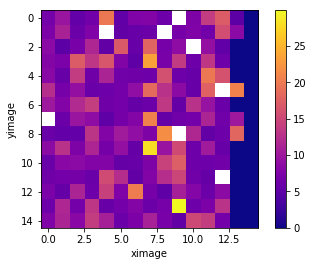

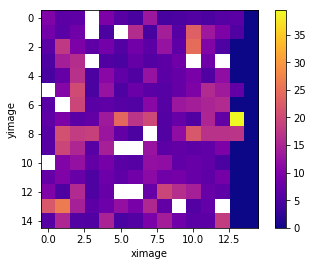

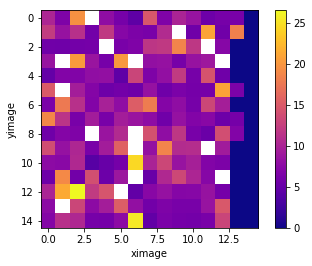

In [260]:
imageNo = 0

for x in range(len(psf)):
    plt.imshow(psf[x],cmap='plasma',interpolation='nearest')
    plt.colorbar()
    plt.xlabel('ximage')
    plt.ylabel('yimage')
    plt.show()

In [219]:
psf[2]

[[1.534, 1.9850000000000001, 1.742, 2.0640000000000001, 1.5109999999999999],
 [3.7949999999999999, 1.464, 1.6679999999999999, 1.542, 5.4119999999999999],
 [1.7035, 2.6520000000000001, 2.3359999999999999, 2.2859999999999996, 1.484],
 [2.1240000000000001,
  1.6625000000000001,
  1.5089999999999999,
  1.7030000000000001,
  1.6950000000000001],
 [2.0960000000000001,
  1.6405000000000001,
  1.7330000000000001,
  1.8210000000000002,
  4.548]]

In [87]:
xcoords = ['pillow','pillow']
ycoords = ['pillow','pillow']

with open('starlist','w') as f:
    writer = csv.writer(f,delimiter=' ')
    writer.writerows(zip(xcoords,ycoords))

In [37]:
names = makeConfig([5,10,3,64])
outTable = findObjects(imagename,names[0],names[1])

In [38]:
df = outTable.to_pandas()
newdf = df.nlargest(1050,'FLUX_ISO')

In [39]:
df2 = newdf[50:1050]

In [45]:
dfbottomtotop = []
os.chdir('/home/mj1e16/iraf/')
length = len(df2)
nsegs = 25
segment = length/nsegs

for segs in range(nsegs):
    low = segs*segment
    high = low+segment
    regiondf = df2.loc[(df['Y_IMAGE'] >= low) & (df['Y_IMAGE'] <= high)]
    xcoords = regiondf['X_IMAGE'].tolist()
    ycoords = regiondf['Y_IMAGE'].tolist()
    with open('starlist','w') as f:
        writer = csv.writer(f,delimiter=' ')
        writer.writerows(zip(xcoords,ycoords))
    psfmeasure('kplr2009115002613_ffi-cal.fits[2]',coords='markall',logfile='logfile_{}_{}'.format('imagename',segs),imagecur='starlist') 


** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Mon 20:01:47 10-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
kplr20091150026  954.77   30.30    0.59   1.471    0.23      54
                 636.38   32.52    1.80   1.354    0.35      75
                 771.76   20.63    2.15   1.672    0.20      54
                 934.28   34.87    2.44   1.308    0.31      54
                 157.70   28.33    0.00   1.999    0.15      71
                1104.99   36.19    4.83   1.293    0.44       4
                 662.95   33.38    2.71   1.942    0.56     -14
                 367.21   29.42    3.22   1.552    0.41       5
                 262.46   23.87    3.27   1.594    0.41      58
                1001.37   35.09    3.51   1.226    0.35      51
                1031.08   33.89    3.57   1.334    0.30      54
                1116.13   14.11    6.72  22.015    0.94     -52


In [9]:
from iraf import psfmeasure

In [10]:
os.chdir('/home/mj1e16/iraf/')

In [20]:
psfmeasure('kplr2009115002613_ffi-cal.fits[44]',coords='markall',logfile='logfile',imagecur='starlist') #)

** Select stars to measure with 'm' and finish with 'q'.
** Additional options are '?', 'g', and :show.
NOAO/IRAF V2.16 mj1e16@uos-201660 Mon 19:56:52 10-Jun-2019

          Image  Column    Line     Mag    FWHM   Ellip      PA SAT
kplr20091150026  684.11  500.74    3.64   1.407    0.17     -69
                 674.83  732.79    0.00   3.940    0.84     -88
                 153.29  644.73    0.24   3.406    0.70     -89

  Average full width at half maximum (FWHM) of 3.6589
